# Combined Tier 1 Paradigms: Deep Research Agent

This notebook implements the **Combined Tier 1 Architecture** that unifies four paradigms:

1. **Cascading Knowledge Cache** - Global search layer wrapping all operations
2. **Agile Sprints** - Information gathering with retrospectives
3. **Iterative Refinement V2** - Skeleton-based document generation with patches
4. **Quality Gates** - Strategic checkpoints for quality assurance

## Architecture Overview

The architecture follows a **funnel pattern**:
```
Wide Research → Structured Synthesis → Focused Refinement → Polished Output
```

### Five Phases:
1. **Phase 1: Agile Research Sprints** - Comprehensive information gathering
2. **Phase 2: Skeleton Generation** - Create document structure
3. **Phase 3: Node Expansion** - Generate prose per section
4. **Phase 4: Verification & Refinement** - Quality gates and patching
5. **Phase 5: Final Assembly** - Compile polished report

## Technology Stack
- **LLM**: gpt-5-mini-2025-08-07
- **Web Search**: Tavily API
- **Embeddings**: OpenAI text-embedding-3-small
- **Tracing**: LangSmith
- **Framework**: LangGraph

## 1. Setup and Configuration

In [ ]:
import os
import operator
import asyncio
import hashlib
import re
import json
from pathlib import Path
from typing import List, Dict, Tuple, Annotated, TypedDict, Literal, Optional, Any
from urllib.parse import urlparse
from datetime import datetime

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

import numpy as np

# Load environment variables
env_path = Path("../../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [ ]:
# Initialize LLM, Tavily, and Embeddings
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0, max_retries=10)
tavily_client = TavilyClient()
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# ===== CONFIGURATION PARAMETERS =====

# Research Phase (Agile Sprints)
MAX_RESEARCH_SPRINTS = 3
QUERIES_PER_SPRINT = 5
MIN_SOURCES_FOR_GATE1 = 15
MIN_DOMAINS_FOR_GATE1 = 5

# Skeleton Generation
TARGET_WORDS_PER_NODE = 300
MIN_SECTIONS = 5
MAX_SECTIONS = 8

# Knowledge Cache
CHUNK_SIZE = 500
CHUNK_OVERLAP = 100
HIGH_CONFIDENCE_THRESHOLD = 0.75
LOW_CONFIDENCE_THRESHOLD = 0.40
SPECIFICITY_ADJUSTMENT = 0.2
TOP_K_RETRIEVAL = 5

# Verification & Refinement
MAX_REFINEMENT_ITERATIONS = 2
QUALITY_THRESHOLD = 7.5
MIN_EVIDENCE_SCORE = 6
MAX_CASCADES_PER_ITERATION = 5

# Token Management
MAX_CONTEXT_CHARS = 12000
MAX_FINDINGS_CHARS = 10000

print(f"Using model: {MODEL_NAME}")
print(f"Research: max {MAX_RESEARCH_SPRINTS} sprints, {QUERIES_PER_SPRINT} queries/sprint")
print(f"Refinement: max {MAX_REFINEMENT_ITERATIONS} iterations, threshold {QUALITY_THRESHOLD}/10")
print(f"Cache: HIGH >= {HIGH_CONFIDENCE_THRESHOLD}, LOW < {LOW_CONFIDENCE_THRESHOLD}")

Using model: gpt-5-mini-2025-08-07
Research: max 3 sprints, 5 queries/sprint
Refinement: max 2 iterations, threshold 7.5/10
Cache: HIGH >= 0.75, LOW < 0.4


## 2. Knowledge Cache Implementation

The Knowledge Cache wraps ALL search operations throughout the agent, providing:
- **Layer 1**: Deterministic deduplication (exact query match)
- **Layer 2**: Semantic similarity retrieval (vector search)
- **Layer 3**: LLM-augmented judgment (gap analysis)

In [ ]:
# ===== Knowledge Cache Data Models =====

class CachedDocument(BaseModel):
    """A cached web document."""
    url: str
    normalized_url: str
    content: str
    content_hash: str
    title: str = ""
    retrieval_timestamp: str
    source_query: str = ""


class CachedChunk(BaseModel):
    """A chunk of content with embedding."""
    chunk_id: str
    text: str
    embedding: List[float]
    source_url: str
    position: int


class CacheDecision(BaseModel):
    """Record of a cache decision for observability."""
    query: str
    layer_reached: Literal["L1", "L2", "L3"]
    decision: str
    confidence_score: float = 0.0
    action_taken: Literal["USE_CACHE", "SEARCH", "TARGETED_SEARCH"]
    reasoning: str = ""
    timestamp: str = ""


class KnowledgeBase:
    """Session-scoped knowledge base with cascading cache capabilities."""

    def __init__(self):
        self.url_registry: Dict[str, CachedDocument] = {}
        self.query_cache: Dict[str, dict] = {}
        self.chunks: List[CachedChunk] = []
        self.chunk_embeddings: Optional[np.ndarray] = None
        self.stats = {
            "total_queries": 0, "l1_hits": 0, "l2_high": 0, "l2_medium": 0,
            "l2_low": 0, "l3_sufficient": 0, "l3_partial": 0, "l3_insufficient": 0,
            "web_searches_executed": 0, "web_searches_avoided": 0
        }

    def normalize_url(self, url: str) -> str:
        try:
            parsed = urlparse(url)
            host = parsed.netloc.lower()
            if host.startswith("www."):
                host = host[4:]
            path = parsed.path.rstrip("/")
            return f"https://{host}{path}"
        except:
            return url.lower()

    def normalize_query_light(self, query: str) -> str:
        return " ".join(query.lower().split())

    def normalize_query_aggressive(self, query: str) -> str:
        stop_words = {"the", "a", "an", "is", "are", "of", "in", "to", "for", "and", "or", "what", "how", "why"}
        light = self.normalize_query_light(query)
        terms = [t for t in light.split() if t not in stop_words and len(t) > 1]
        return " ".join(sorted(terms))

    def compute_content_hash(self, content: str) -> str:
        return hashlib.sha256(content.encode()).hexdigest()

    def add_document(self, url: str, content: str, title: str = "", source_query: str = ""):
        normalized_url = self.normalize_url(url)
        doc = CachedDocument(
            url=url, normalized_url=normalized_url, content=content,
            content_hash=self.compute_content_hash(content), title=title,
            retrieval_timestamp=datetime.now().isoformat(), source_query=source_query
        )
        self.url_registry[normalized_url] = doc
        self._chunk_and_embed(doc)
        return doc

    def _chunk_and_embed(self, doc: CachedDocument):
        content = doc.content
        chunks_text = []
        for i in range(0, len(content), CHUNK_SIZE - CHUNK_OVERLAP):
            chunk_text = content[i:i + CHUNK_SIZE]
            if len(chunk_text) > 50:
                chunks_text.append(chunk_text)
        if not chunks_text:
            return
        embeddings = embeddings_model.embed_documents(chunks_text)
        for i, (text, embedding) in enumerate(zip(chunks_text, embeddings)):
            chunk = CachedChunk(
                chunk_id=f"{doc.content_hash[:8]}_{i}", text=text,
                embedding=embedding, source_url=doc.url, position=i
            )
            self.chunks.append(chunk)
        self._update_embedding_matrix()

    def _update_embedding_matrix(self):
        if self.chunks:
            self.chunk_embeddings = np.array([c.embedding for c in self.chunks])

    def add_query(self, query: str, result_urls: List[str], result_summary: str):
        entry = {
            "original_query": query, "light_normalized": self.normalize_query_light(query),
            "aggressive_normalized": self.normalize_query_aggressive(query),
            "timestamp": datetime.now().isoformat(), "result_urls": result_urls,
            "result_summary": result_summary
        }
        self.query_cache[entry["light_normalized"]] = entry
        self.query_cache[entry["aggressive_normalized"]] = entry
        return entry

    def lookup_query_exact(self, query: str) -> Optional[dict]:
        return self.query_cache.get(self.normalize_query_light(query))

    def semantic_search(self, query: str, top_k: int = TOP_K_RETRIEVAL) -> List[Tuple[CachedChunk, float]]:
        if not self.chunks or self.chunk_embeddings is None:
            return []
        query_embedding = np.array(embeddings_model.embed_query(query))
        similarities = np.dot(self.chunk_embeddings, query_embedding) / (
            np.linalg.norm(self.chunk_embeddings, axis=1) * np.linalg.norm(query_embedding) + 1e-8
        )
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        return [(self.chunks[idx], float(similarities[idx])) for idx in top_indices]

    def get_stats_summary(self) -> str:
        total = self.stats["total_queries"]
        if total == 0:
            return "No queries processed yet."
        avoided = self.stats["web_searches_avoided"]
        hit_rate = avoided / total * 100 if total > 0 else 0
        return f"Total: {total} queries, {avoided} avoided ({hit_rate:.1f}% hit rate), {len(self.chunks)} chunks cached"


# Initialize global knowledge base
knowledge_base = KnowledgeBase()
print("Knowledge base initialized")

Knowledge base initialized


In [ ]:
# ===== Cascaded Search Function =====

def search_web(query: str, max_results: int = 8) -> Tuple[str, List[str], List[str], List[Dict[str, Any]]]:
    """Execute web search using Tavily. Returns (summary, results, urls, raw_results).

    raw_results contains the full Tavily response including relevance scores for validation.
    """
    try:
        if len(query) > 400:
            query = query[:400]
        response = tavily_client.search(query=query, max_results=max_results, include_answer=True)
        results = []
        urls = []
        raw_results = []
        summary = response.get("answer", "")
        for r in response.get("results", []):
            url = r.get('url', '')
            urls.append(url)
            content = r.get('content', '')[:500]
            title = r.get('title', 'No title')
            score = r.get('score', 0.0)  # Tavily relevance score
            results.append(f"[{title}] {content}... (Source: {url})")
            # Store raw result for validation
            raw_results.append({
                "url": url,
                "title": title,
                "content": content,
                "full_content": r.get('content', ''),
                "tavily_score": score,
                "query": query
            })
        return summary, results, urls, raw_results
    except Exception as e:
        return f"Search error: {str(e)}", [], [], []


def compute_confidence(top_results: List[Tuple[CachedChunk, float]], query: str) -> float:
    """Compute multi-signal confidence score."""
    if not top_results:
        return 0.0
    top_score = top_results[0][1]
    score_gap = top_results[0][1] - top_results[1][1] if len(top_results) > 1 else top_score
    query_terms = set(query.lower().split())
    top_chunk_terms = set(top_results[0][0].text.lower().split())
    term_overlap = len(query_terms & top_chunk_terms) / len(query_terms | top_chunk_terms) if query_terms | top_chunk_terms else 0
    return 0.5 * top_score + 0.25 * min(score_gap * 2, 1.0) + 0.25 * term_overlap


async def cascaded_search(query: str, kb: KnowledgeBase) -> Tuple[str, List[str], CacheDecision, List[Dict[str, Any]]]:
    """Execute full cascading cache check and search if needed.

    Returns: (content, urls, cache_decision, raw_results)
    raw_results contains Tavily results with scores for validation (empty if cache hit).
    """
    kb.stats["total_queries"] += 1
    timestamp = datetime.now().isoformat()

    # Layer 1: Exact match
    exact_match = kb.lookup_query_exact(query)
    if exact_match:
        kb.stats["l1_hits"] += 1
        kb.stats["web_searches_avoided"] += 1
        return exact_match["result_summary"], exact_match["result_urls"], CacheDecision(
            query=query, layer_reached="L1", decision="HIT", confidence_score=1.0,
            action_taken="USE_CACHE", reasoning="Exact query match", timestamp=timestamp
        ), []  # No raw results for cache hit

    # Layer 2: Semantic search
    results = kb.semantic_search(query)
    if results:
        confidence = compute_confidence(results, query)
        if confidence >= HIGH_CONFIDENCE_THRESHOLD:
            kb.stats["l2_high"] += 1
            kb.stats["web_searches_avoided"] += 1
            content = "\n\n".join([f"[From: {c.source_url}]\n{c.text}" for c, _ in results[:3]])
            urls = list(set([c.source_url for c, _ in results]))
            return content, urls, CacheDecision(
                query=query, layer_reached="L2", decision="HIGH_CONF", confidence_score=confidence,
                action_taken="USE_CACHE", reasoning=f"High semantic similarity ({confidence:.2f})", timestamp=timestamp
            ), []  # No raw results for cache hit
        elif confidence >= LOW_CONFIDENCE_THRESHOLD:
            kb.stats["l2_medium"] += 1
            # For medium confidence, still do a search but could use cached context
        else:
            kb.stats["l2_low"] += 1

    # Execute web search
    summary, search_results, urls, raw_results = search_web(query)
    kb.stats["web_searches_executed"] += 1

    # Cache results
    query_content = f"Query: {query}\n\nAnswer: {summary}\n\nResults:\n" + "\n\n".join(search_results)
    synthetic_url = f"search://{kb.compute_content_hash(query)[:16]}"
    kb.add_document(synthetic_url, query_content, title=f"Search: {query[:50]}", source_query=query)
    kb.add_query(query, urls, summary)

    return query_content, urls, CacheDecision(
        query=query, layer_reached="L2", decision="LOW_CONF",
        confidence_score=compute_confidence(results, query) if results else 0.0,
        action_taken="SEARCH", reasoning="Executed web search", timestamp=timestamp
    ), raw_results


print("Cascaded search function defined")

Cascaded search function defined


## 3. State Definition and Data Models

In [ ]:
# ===== Skeleton and Prose Models =====

class SkeletonNode(BaseModel):
    """A node in the document skeleton hierarchy."""
    node_id: str = Field(description="Unique identifier like 'sec:intro'")
    title: str = Field(description="Section title")
    intent: str = Field(description="1-3 sentence description of purpose")
    target_word_count: int = Field(description="Target word count for this section, typically 200-500")
    dependencies: List[str] = Field(description="List of node_ids this section depends on - use empty list [] if none")
    children: List[str] = Field(description="List of child node_ids - use empty list [] if no children")
    is_expanded: bool = Field(description="Whether this section has been expanded - always false initially")


class SkeletonGenerationOutput(BaseModel):
    """Output schema for skeleton generation."""
    thesis: str = Field(description="One-sentence thesis statement")
    sections: List[SkeletonNode] = Field(description="All sections in document order")


class ProseGenerationOutput(BaseModel):
    """Output schema for prose generation."""
    bridge_in: str = Field(description="Transitional sentences from previous section")
    main_content: str = Field(description="Main prose content")
    bridge_out: str = Field(description="Transitional sentences to next section")
    summary: str = Field(description="1-2 sentence summary")


class Claim(BaseModel):
    """A verifiable assertion in the document."""
    claim_id: str
    claim_text: str
    source_node: str
    verification_status: Literal["unverified", "verified", "contested"] = Field(description="Verification status")
    supporting_evidence: List[str] = Field(description="List of evidence URLs - use empty list [] if none")


class ClaimExtractionOutput(BaseModel):
    """Output for claim extraction."""
    claims: List[Claim]


class CritiqueIssue(BaseModel):
    """An issue identified during critique."""
    issue_id: str
    scope: Literal["global", "section", "transition"]
    target_nodes: List[str]
    issue_type: str
    severity: Literal["critical", "major", "minor"]
    description: str
    suggestion: str
    search_query: str = Field(description="Search query to find better evidence - empty string if not needed")


class CritiqueResult(BaseModel):
    """Complete critique output."""
    overall_quality: float = Field(description="Quality score 1-10")
    issues: List[CritiqueIssue] = Field(description="List of issues found - use empty list [] if no issues")
    summary: str


# ===== NEW: Source Validation Models =====

class ValidatedSource(BaseModel):
    """A validated source with relevance scoring."""
    url: str
    title: str = ""
    content_snippet: str = ""
    relevance_score: float = Field(ge=0, le=1, description="Relevance score 0-1")
    tavily_score: float = Field(ge=0, le=1, default=0.0, description="Tavily's relevance score")
    source_type: Literal["primary", "secondary", "unknown"] = "unknown"
    is_accessible: bool = True
    rejection_reason: str = ""


class SourceValidationOutput(BaseModel):
    """Output for source validation LLM call."""
    relevance_score: int = Field(ge=1, le=10, description="Relevance 1-10")
    source_type: Literal["primary", "secondary"] = Field(description="Source type: primary or secondary")
    reasoning: str = Field(description="Brief explanation of relevance assessment")


# ===== NEW: Audience Analysis Models =====

class AudienceProfile(BaseModel):
    """Profile of the target audience for calibrating output."""
    primary_audience: Literal["decision_makers", "analysts", "general_readers", "researchers"] = "analysts"
    audience_needs: List[str] = Field(default_factory=list)
    methodology_weight: float = Field(ge=0.1, le=0.3, default=0.15, description="How much methodology to include")
    executive_summary_priority: Literal["high", "medium", "low"] = "high"
    recommendation_style: Literal["prescriptive", "analytical", "educational"] = "analytical"
    jargon_level: Literal["low", "medium", "high"] = "medium"


class AudienceAnalysisOutput(BaseModel):
    """Output schema for audience analysis."""
    primary_audience: str
    audience_needs: List[str]
    methodology_weight: float
    executive_summary_priority: str
    recommendation_style: str
    jargon_level: str


# ===== NEW: Claims Verification Models =====

class ExtractedClaim(BaseModel):
    """A claim extracted from prose for verification."""
    claim_text: str = Field(description="The exact factual assertion")
    claim_type: Literal["statistic", "fact", "trend", "comparison", "causation"] = Field(description="Type of claim")
    cited_url: str = Field(description="URL cited for this claim, empty string if none")
    source_node: str = Field(description="Section this claim came from")
    verification_needed: bool = Field(description="Whether this claim requires source verification")


class ClaimVerificationResult(BaseModel):
    """Result of verifying a claim against its source."""
    supported: Literal["true", "false", "partial"] = Field(description="Whether claim is supported: true, false, or partial")
    source_quote: str = Field(description="Relevant quote from source if found, empty string if none")
    issue: str = Field(description="Description if not fully supported, empty string if fully supported")


class ClaimsExtractionOutput(BaseModel):
    """Output for extracting claims from a section."""
    claims: List[ExtractedClaim]


# ===== NEW: Executive Summary Models =====

class KeyTakeaway(BaseModel):
    """A key takeaway for the executive summary."""
    takeaway: str
    confidence: Literal["High", "Medium", "Low"] = Field(description="Confidence level: High, Medium, or Low")


class ExecutiveSummaryOutput(BaseModel):
    """Output for executive summary generation."""
    main_finding: str = Field(description="One sentence core conclusion")
    key_takeaways: List[KeyTakeaway] = Field(description="3-5 key takeaways with confidence")
    bottom_line: str = Field(description="One sentence actionable implication")


# ===== NEW: Decision Framework Models =====

class Recommendation(BaseModel):
    """A recommendation in the decision framework."""
    action: str = Field(description="Specific action to take")
    rationale: str = Field(description="Why this action")
    conditions: str = Field(description="When this applies - use 'Always applicable' if no specific conditions")
    priority: Literal["High", "Medium", "Low"] = Field(description="Priority level: High, Medium, or Low")


class DecisionFrameworkOutput(BaseModel):
    """Output for decision framework generation."""
    primary_recommendations: List[Recommendation] = Field(description="1-3 most important actions")
    conditional_recommendations: List[Recommendation] = Field(description="If X then Y recommendations - use empty list [] if none")
    monitoring_indicators: List[str] = Field(description="What to watch going forward - use empty list [] if none")


# ===== NEW: Confidence Assessment Models =====

class ConfidenceAssessment(BaseModel):
    """Confidence assessment for a conclusion."""
    conclusion: str
    confidence: Literal["High", "Medium", "Low"] = Field(description="Confidence level: High, Medium, or Low")
    evidence_quality: Literal["strong", "moderate", "weak"] = Field(description="Evidence quality: strong, moderate, or weak")
    source_count: int = Field(description="Number of sources supporting this conclusion")
    key_uncertainty: str = Field(description="Main uncertainty or limitation")
    what_would_change_this: str = Field(description="What evidence would change this conclusion")


class ConfidenceAssessmentOutput(BaseModel):
    """Output for confidence level assessment."""
    assessments: List[ConfidenceAssessment]
    overall_confidence: Literal["High", "Medium", "Low"] = Field(description="Overall confidence: High, Medium, or Low")
    limitations_summary: str = Field(description="Summary of key limitations and uncertainties")


# ===== NEW: Updated Prose Generation Output =====

class ClaimEntry(BaseModel):
    """A claim made in prose content."""
    claim: str = Field(description="The factual claim being made")
    source_url: str = Field(description="URL of the source supporting this claim, or empty string if no specific source")


class ProseGenerationOutputV2(BaseModel):
    """Updated output schema for prose generation - no bridge sentences."""
    main_content: str = Field(description="Main prose content")
    section_conclusion: str = Field(description="1-2 sentence summary of what this section established")
    claims_made: List[ClaimEntry] = Field(description="List of claims made in this section - use empty list [] if no specific claims")


print("Data models defined")

Data models defined


In [ ]:
# ===== Combined Tier 1 State =====

class CombinedTier1State(TypedDict):
    """State for the Combined Tier 1 Deep Research Agent."""
    # Input
    question: str

    # ===== PHASE 1: Research Sprints =====
    research_backlog: List[str]  # REPLACED each sprint
    current_research_sprint: int
    max_research_sprints: int
    sprint_findings: Annotated[List[str], operator.add]  # ACCUMULATED
    research_source_urls: Annotated[List[str], operator.add]
    research_retrospective_notes: Annotated[List[str], operator.add]
    research_summary: str
    research_complete: bool

    # ===== NEW: Source Validation =====
    validated_sources: Dict[str, Dict[str, Any]]  # url -> ValidatedSource dict
    rejected_sources: Annotated[List[Dict[str, Any]], operator.add]  # {url, reason, query}
    raw_search_results: Annotated[List[Dict[str, Any]], operator.add]  # Store raw Tavily results for validation

    # ===== NEW: Audience Analysis =====
    audience_profile: Dict[str, Any]  # AudienceProfile dict

    # ===== PHASE 2: Skeleton =====
    skeleton: Dict[str, Any]
    skeleton_validated: bool

    # ===== PHASE 3: Node Expansion =====
    prose_store: Dict[str, Dict[str, Any]]
    claims_registry: Dict[str, Dict[str, Any]]
    nodes_expanded: List[str]

    # ===== NEW: Claims Verification =====
    extracted_claims: Annotated[List[Dict[str, Any]], operator.add]  # All claims from prose
    verified_claims: Dict[str, Dict[str, Any]]  # claim_id -> verification result
    claims_needing_revision: List[str]  # claim_ids that failed verification

    # ===== PHASE 4: Verification =====
    noise_map: List[Dict[str, Any]]
    nodes_to_patch: List[str]
    cascade_queue: List[str]
    targeted_evidence: Dict[str, List[str]]
    current_refinement_iteration: int
    max_refinement_iterations: int
    quality_scores: Annotated[List[float], operator.add]
    verification_log: Annotated[List[str], operator.add]

    # ===== NEW: Output Components =====
    executive_summary: str
    decision_framework: str
    confidence_assessments: List[Dict[str, Any]]
    limitations_summary: str

    # ===== PHASE 5: Output =====
    final_report: str

    # ===== NEW: Quality Tracking =====
    information_density_score: float  # Novel info per 100 words
    self_reference_count: int  # Should be 0
    methodology_ratio: float  # Should be < 0.2

    # ===== METRICS =====
    total_searches: int
    cache_hits: int
    cache_decisions: Annotated[List[Dict], operator.add]


print("Combined state defined")

Combined state defined


## 4. Phase 1: Agile Research Sprints

This phase decomposes the question, executes sprints with retrospectives, and produces a compressed research brief.

In [ ]:
# ===== Phase 1 Prompts =====

DECOMPOSE_PROMPT = """You are a research planning expert. Decompose this research question into 5-7 specific sub-questions.

Research Question: {question}

Generate a prioritized list of specific, focused research questions that together will comprehensively answer the main question. Each should be independently searchable.

Return as a numbered list (highest priority first):
1. [Most critical sub-question]
2. [Second priority]
...
"""

SPRINT_SYNTHESIS_PROMPT = """You are a research agent conducting Sprint {sprint_num} of {max_sprints}.

Current research focus: {current_questions}

Based on the search results below, extract key findings addressing these questions.
Be specific and cite sources with URLs.

Search Results:
{search_results}

Provide a comprehensive summary of findings (400-600 words) with specific facts and source URLs.
"""

RETROSPECTIVE_PROMPT = """You are conducting a sprint retrospective for a research project.

Original Question: {original_question}

Sprint {sprint_num} of {max_sprints} has completed.

Summary of findings so far:
{findings_summary}

Current remaining questions:
{remaining_backlog}

Provide a STRUCTURED response:

## LEARNINGS
Key insights from this sprint.

## GAPS
What is still unclear or needs investigation?

## CONTINUE
Should we continue with another sprint? Answer YES or NO.

## NEW_QUESTIONS
List 2-4 NEW questions that emerged (or "None"):
- [New question 1]
- [New question 2]

## REPRIORITIZED_BACKLOG
Reorder remaining questions by priority:
1. [Highest priority]
2. [Next priority]
...
"""

COMPRESS_FINDINGS_PROMPT = """Summarize these research findings into a concise research brief.

All Findings:
{all_findings}

Create a bullet-point summary (max 600 words) capturing:
- Key facts and statistics
- Main themes and patterns
- Important sources
- Any contradictions identified

Be concise but preserve critical information.
"""

print("Phase 1 prompts defined")

Phase 1 prompts defined


In [ ]:
# ===== Phase 1 Node Functions =====

async def decompose_question(state: CombinedTier1State) -> dict:
    """Decompose the research question into a backlog of sub-questions."""
    if state is None:
        raise ValueError("State is None in decompose_question")
    
    question = state.get("question", "")
    if not question:
        raise ValueError("Question is missing or empty in state")
    
    print(f"\n{'='*60}")
    print("Phase 1a: Question Decomposition")
    print(f"{'='*60}")
    
    prompt = DECOMPOSE_PROMPT.format(question=question)
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    
    lines = response.content.strip().split("\n")
    backlog = []
    for line in lines:
        line = line.strip()
        if line and (line[0].isdigit() or line.startswith("-")):
            clean = line.lstrip("0123456789.-) ").strip()
            if clean:
                backlog.append(clean)
    
    print(f"  Created backlog with {len(backlog)} research questions")
    for i, q in enumerate(backlog[:5], 1):
        print(f"    {i}. {q[:60]}...")
    
    return {
        "research_backlog": backlog,
        "current_research_sprint": 1,
        "max_research_sprints": MAX_RESEARCH_SPRINTS,
        "research_complete": False
    }


async def execute_research_sprint(state: CombinedTier1State) -> dict:
    """Execute a research sprint on top backlog items."""
    if state is None:
        raise ValueError("State is None in execute_research_sprint")

    backlog = state.get("research_backlog", [])
    current_sprint = state.get("current_research_sprint", 1)
    max_sprints = state.get("max_research_sprints", MAX_RESEARCH_SPRINTS)

    print(f"\n{'='*60}")
    print(f"Phase 1b: Research Sprint {current_sprint}/{max_sprints}")
    print(f"{'='*60}")

    if not backlog:
        return {"sprint_findings": ["No questions in backlog."]}

    # Take top questions for this sprint
    current_questions = backlog[:QUERIES_PER_SPRINT]

    all_content = []
    all_urls = []
    all_decisions = []
    all_raw_results = []  # NEW: Collect raw results for validation

    for i, question in enumerate(current_questions, 1):
        print(f"  [{i}/{len(current_questions)}] {question[:50]}...")
        content, urls, decision, raw_results = await cascaded_search(question, knowledge_base)
        all_content.append(f"### {question}\n{content}")
        all_urls.extend(urls)
        all_decisions.append(decision.model_dump())
        all_raw_results.extend(raw_results)  # Collect for validation

        action = "CACHE" if decision.action_taken == "USE_CACHE" else "SEARCH"
        print(f"      {action} | Layer: {decision.layer_reached}")

    # Synthesize findings
    combined_results = "\n\n---\n\n".join(all_content)
    if len(combined_results) > 12000:
        combined_results = combined_results[:12000] + "\n...[truncated]"

    synthesis_prompt = SPRINT_SYNTHESIS_PROMPT.format(
        sprint_num=current_sprint,
        max_sprints=max_sprints,
        current_questions="\n".join(f"- {q}" for q in current_questions),
        search_results=combined_results
    )

    synthesis = await llm.ainvoke([HumanMessage(content=synthesis_prompt)])
    finding = f"## Sprint {current_sprint} Findings\n\n{synthesis.content}"

    # Update backlog (remove processed questions)
    updated_backlog = backlog[QUERIES_PER_SPRINT:]

    print(f"  Synthesized {len(synthesis.content)} chars, {len(all_urls)} sources")
    print(f"  Collected {len(all_raw_results)} raw results for validation")

    return {
        "sprint_findings": [finding],
        "research_source_urls": all_urls,
        "cache_decisions": all_decisions,
        "research_backlog": updated_backlog,
        "raw_search_results": all_raw_results  # NEW: Pass to validate_sources
    }


print("Phase 1 node functions defined (part 1)")

Phase 1 node functions defined (part 1)


In [ ]:
# ===== NEW: Source Validation Node =====

SOURCE_VALIDATION_PROMPT = """You are evaluating the relevance of a source to a research query.

Query: {query}

Source Title: {title}
Source URL: {url}
Source Content Snippet:
{content_snippet}

Rate the relevance of this source on a scale of 1-10:
- 10: Directly answers the query with authoritative, primary information
- 7-9: Highly relevant, provides substantial supporting information
- 4-6: Somewhat relevant, tangentially related
- 1-3: Not relevant, completely different topic

Also classify the source type:
- "primary": Official documents, company filings, government data, academic papers, official announcements
- "secondary": News articles, blog posts, analysis pieces, commentary, aggregator sites

IMPORTANT: Be strict. Sources that are:
- Retail/e-commerce sites (amazon, ebay, etc.) = score 1-2
- Generic dictionary definitions = score 1-2
- Unrelated conference/event pages = score 1-2
- Random corporate homepages without relevant content = score 1-3

Output your assessment."""

# Minimum Tavily score threshold for initial filtering
MIN_TAVILY_SCORE = 0.3
# Minimum LLM relevance score (1-10) to keep source
MIN_RELEVANCE_SCORE = 5
# Skip LLM check if Tavily score is very high
HIGH_TAVILY_SCORE_THRESHOLD = 0.85


async def validate_sources(state: CombinedTier1State) -> dict:
    """Validate and filter sources based on relevance.

    This node filters out irrelevant URLs before they pollute the knowledge base.
    Uses Tavily's score and optionally LLM judgment for borderline cases.
    """
    if state is None:
        raise ValueError("State is None in validate_sources")

    raw_results = state.get("raw_search_results", [])
    existing_validated = state.get("validated_sources", {})

    print(f"\n{'='*60}")
    print("Phase 1b.1: Source Validation")
    print(f"{'='*60}")

    if not raw_results:
        print("  No new sources to validate")
        return {"validated_sources": existing_validated, "rejected_sources": []}

    validated_sources = dict(existing_validated)  # Copy existing
    rejected_sources = []

    # Deduplicate by URL
    seen_urls = set(validated_sources.keys())
    unique_results = []
    for r in raw_results:
        url = r.get("url", "")
        if url and url not in seen_urls:
            seen_urls.add(url)
            unique_results.append(r)

    print(f"  Processing {len(unique_results)} unique new sources")

    for i, result in enumerate(unique_results):
        url = result.get("url", "")
        title = result.get("title", "")
        content = result.get("content", "")
        tavily_score = result.get("tavily_score", 0.0)
        query = result.get("query", "")

        # Quick rejection based on Tavily score
        if tavily_score < MIN_TAVILY_SCORE:
            rejected_sources.append({
                "url": url,
                "reason": f"Tavily score too low ({tavily_score:.2f} < {MIN_TAVILY_SCORE})",
                "query": query
            })
            continue

        # Quick acceptance for very high Tavily scores
        if tavily_score >= HIGH_TAVILY_SCORE_THRESHOLD:
            validated_sources[url] = {
                "url": url,
                "title": title,
                "content_snippet": content[:300],
                "relevance_score": tavily_score,
                "tavily_score": tavily_score,
                "source_type": "unknown",  # Would need LLM to classify
                "is_accessible": True,
                "rejection_reason": ""
            }
            continue

        # For medium scores, use LLM to validate
        try:
            validation_prompt = SOURCE_VALIDATION_PROMPT.format(
                query=query,
                title=title,
                url=url,
                content_snippet=content[:500]
            )

            structured_llm = llm.with_structured_output(SourceValidationOutput, method="function_calling")
            result_validation = await structured_llm.ainvoke([HumanMessage(content=validation_prompt)])

            llm_score = result_validation.relevance_score / 10.0  # Normalize to 0-1
            combined_score = (tavily_score + llm_score) / 2

            if result_validation.relevance_score >= MIN_RELEVANCE_SCORE:
                validated_sources[url] = {
                    "url": url,
                    "title": title,
                    "content_snippet": content[:300],
                    "relevance_score": combined_score,
                    "tavily_score": tavily_score,
                    "source_type": result_validation.source_type,
                    "is_accessible": True,
                    "rejection_reason": ""
                }
            else:
                rejected_sources.append({
                    "url": url,
                    "reason": f"LLM relevance score too low ({result_validation.relevance_score}/10): {result_validation.reasoning}",
                    "query": query
                })

        except Exception as e:
            # If LLM validation fails, use Tavily score alone
            if tavily_score >= 0.5:
                validated_sources[url] = {
                    "url": url,
                    "title": title,
                    "content_snippet": content[:300],
                    "relevance_score": tavily_score,
                    "tavily_score": tavily_score,
                    "source_type": "unknown",
                    "is_accessible": True,
                    "rejection_reason": ""
                }
            else:
                rejected_sources.append({
                    "url": url,
                    "reason": f"Validation failed and Tavily score borderline: {str(e)}",
                    "query": query
                })

    print(f"  Validated: {len(validated_sources)} sources")
    print(f"  Rejected: {len(rejected_sources)} sources")

    # Show some rejections for debugging
    if rejected_sources:
        print(f"  Sample rejections:")
        for r in rejected_sources[:3]:
            print(f"    - {r['url'][:50]}... : {r['reason'][:60]}")

    return {
        "validated_sources": validated_sources,
        "rejected_sources": rejected_sources
    }


print("Source validation node defined")

Source validation node defined


In [ ]:
# ===== Phase 1 Node Functions (continued) =====

def parse_reprioritized_backlog(response_content: str) -> List[str]:
    """Parse reprioritized backlog from retrospective."""
    backlog_match = re.search(r'## REPRIORITIZED_BACKLOG\s*(.*?)(?=##|$)', response_content, re.DOTALL | re.IGNORECASE)
    if backlog_match:
        backlog_text = backlog_match.group(1)
        questions = []
        for line in backlog_text.strip().split("\n"):
            line = line.strip()
            if line and (line[0].isdigit() or line.startswith("-")):
                clean = re.sub(r'^[\d\.\-\)\s]+', '', line).strip()
                if clean and len(clean) > 10:
                    questions.append(clean)
        return questions
    return []


def parse_should_continue_research(response_content: str) -> bool:
    """Parse whether to continue from retrospective."""
    continue_match = re.search(r'## CONTINUE\s*(.*?)(?=##|$)', response_content, re.DOTALL | re.IGNORECASE)
    if continue_match:
        text = continue_match.group(1).strip().lower()
        negative_patterns = [r'^no\b', r'should\s+stop', r'sufficient', r'adequately']
        for pattern in negative_patterns:
            if re.search(pattern, text):
                return False
    return True


async def research_retrospective(state: CombinedTier1State) -> dict:
    """Conduct retrospective after research sprint."""
    if state is None:
        raise ValueError("State is None in research_retrospective")
    
    question = state.get("question", "")
    if not question:
        raise ValueError("Question is missing or empty in state")
        
    current_sprint = state.get("current_research_sprint", 1)
    max_sprints = state.get("max_research_sprints", MAX_RESEARCH_SPRINTS)
    all_findings = "\n\n".join(state.get("sprint_findings", []))
    backlog = state.get("research_backlog", [])
    
    print(f"\n{'='*60}")
    print(f"Phase 1c: Sprint {current_sprint} Retrospective")
    print(f"{'='*60}")
    
    # Summarize findings for token efficiency
    if len(all_findings) > 4000:
        compress_prompt = COMPRESS_FINDINGS_PROMPT.format(all_findings=all_findings[:8000])
        compress_response = await llm.ainvoke([HumanMessage(content=compress_prompt)])
        findings_summary = compress_response.content
    else:
        findings_summary = all_findings
    
    prompt = RETROSPECTIVE_PROMPT.format(
        original_question=question,
        sprint_num=current_sprint,
        max_sprints=max_sprints,
        findings_summary=findings_summary,
        remaining_backlog="\n".join(f"- {q}" for q in backlog) if backlog else "None"
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    
    reprioritized = parse_reprioritized_backlog(response.content)
    should_continue = parse_should_continue_research(response.content)
    
    if not reprioritized and backlog:
        reprioritized = backlog
    
    print(f"  Should continue: {should_continue}")
    print(f"  Backlog size: {len(reprioritized)}")
    
    return {
        "research_retrospective_notes": [f"### Sprint {current_sprint} Retrospective\n{response.content}"],
        "current_research_sprint": current_sprint + 1,
        "research_backlog": reprioritized,
        "research_summary": findings_summary,
        "research_complete": not should_continue
    }


async def quality_gate_1(state: CombinedTier1State) -> dict:
    """Check source sufficiency before moving to synthesis."""
    if state is None:
        raise ValueError("State is None in quality_gate_1")
        
    source_urls = state.get("research_source_urls", [])
    unique_urls = list(set(source_urls))
    
    # Count unique domains
    domains = set()
    for url in unique_urls:
        try:
            parsed = urlparse(url)
            domains.add(parsed.netloc)
        except:
            pass
    
    print(f"\n{'='*60}")
    print("Quality Gate 1: Source Sufficiency")
    print(f"{'='*60}")
    print(f"  Unique sources: {len(unique_urls)} (min: {MIN_SOURCES_FOR_GATE1})")
    print(f"  Unique domains: {len(domains)} (min: {MIN_DOMAINS_FOR_GATE1})")
    
    passed = len(unique_urls) >= MIN_SOURCES_FOR_GATE1 and len(domains) >= MIN_DOMAINS_FOR_GATE1
    print(f"  Gate 1 {'PASSED' if passed else 'PASSED (relaxed)'}")  # Always pass but note
    
    return {"research_complete": True}


async def compress_findings(state: CombinedTier1State) -> dict:
    """Compress all findings into a research brief for skeleton generation."""
    if state is None:
        raise ValueError("State is None in compress_findings")
        
    all_findings = "\n\n".join(state.get("sprint_findings", []))
    
    print(f"\n{'='*60}")
    print("Phase 1d: Compressing Research Brief")
    print(f"{'='*60}")
    
    if len(all_findings) > MAX_FINDINGS_CHARS:
        prompt = COMPRESS_FINDINGS_PROMPT.format(all_findings=all_findings[:MAX_FINDINGS_CHARS])
        response = await llm.ainvoke([HumanMessage(content=prompt)])
        summary = response.content
    else:
        summary = all_findings
    
    print(f"  Compressed to {len(summary)} chars")
    
    return {"research_summary": summary}


def should_continue_research(state: CombinedTier1State) -> Literal["execute_sprint", "quality_gate_1"]:
    """Decide whether to continue research or move to quality gate."""
    if state is None:
        return "quality_gate_1"
        
    current_sprint = state.get("current_research_sprint", 1)
    max_sprints = state.get("max_research_sprints", MAX_RESEARCH_SPRINTS)
    backlog = state.get("research_backlog", [])
    research_complete = state.get("research_complete", False)
    
    if current_sprint > max_sprints:
        print(f"  Max sprints reached. Moving to Quality Gate 1.")
        return "quality_gate_1"
    if not backlog:
        print(f"  Backlog empty. Moving to Quality Gate 1.")
        return "quality_gate_1"
    if research_complete:
        print(f"  Research marked complete. Moving to Quality Gate 1.")
        return "quality_gate_1"
    
    print(f"  Continuing to sprint {current_sprint}.")
    return "execute_sprint"


print("Phase 1 node functions defined (part 2)")

Phase 1 node functions defined (part 2)


## 5. Phase 2: Skeleton Generation

Creates a hierarchical document structure before writing prose.

In [ ]:
# ===== Phase 2: Skeleton Generation =====

SKELETON_PROMPT = """You are a research document architect. Create a document skeleton optimized for {primary_audience}.

Research Question: {question}

Research Findings Summary:
{research_summary}

Audience Profile:
- Primary Audience: {primary_audience}
- Methodology Weight: {methodology_weight} (0.1 = minimal, 0.3 = detailed)
- Recommendation Style: {recommendation_style}

Create a document structure that prioritizes FINDINGS over METHODOLOGY.

Each section needs:
- node_id: Unique identifier like "sec:exec_summary", "sec:background"
- title: Descriptive section title
- intent: 1-3 sentences describing what this section DELIVERS (not what it will do)
- target_word_count: Varies by section (see below)
- dependencies: List of node_ids this section builds upon (empty for first section)
- children: Empty list (flat structure)

REQUIRED STRUCTURE (in this order):

1. sec:exec_summary - Executive Summary (~300 words)
   - intent: Synthesize key findings for quick consumption. NO methodology here.
   - This section must deliver conclusions and implications upfront.

2. sec:background - Background/Context (~200 words)
   - intent: Establish ONLY essential context needed to understand findings.
   - Keep brief - this is NOT where methodology goes.

3-5. Main Analysis Sections (3 sections, ~400 words each)
   - intent: Present specific findings with evidence and citations.
   - Each section should cover a distinct aspect of the research question.
   - Name these based on the actual content (e.g., "sec:market_trends", "sec:technology_impact")

6. sec:synthesis - Synthesis/Discussion (~300 words)
   - intent: Integrate findings across sections, address counterarguments.
   - Discuss implications and connections between findings.

7. sec:recommendations - Recommendations/Implications (~300 words)
   - intent: Provide actionable guidance based on findings.
   - Include prioritized recommendations for the target audience.

CRITICAL RULES:
- Do NOT create sections that describe what the report will do ("This section will...")
- Do NOT include "testable hypotheses" or "parameter ranges"
- Do NOT promise appendices, artifacts, or external materials
- Do NOT front-load methodology - if needed, it goes in a brief note at the end
- Each section should DELIVER content, not ANNOUNCE what it will cover
- The thesis statement should be a direct answer/position, not a process description

BANNED SECTION TYPES:
- "Methodology Overview"
- "Research Approach"
- "Analytical Framework"
- "Hypothesis Testing"

Generate a thesis statement (one sentence that states a conclusion) and the sections list.
"""


def validate_skeleton(skeleton: Dict[str, Any]) -> Tuple[bool, List[str]]:
    """Validate skeleton structure."""
    issues = []
    nodes = skeleton.get("nodes", {})
    root_nodes = skeleton.get("root_nodes", [])
    
    for root_id in root_nodes:
        if root_id not in nodes:
            issues.append(f"Root node '{root_id}' not found")
    
    for node_id, node in nodes.items():
        for dep_id in node.get("dependencies", []):
            if dep_id not in nodes:
                issues.append(f"Node '{node_id}' depends on non-existent '{dep_id}'")
    
    return len(issues) == 0, issues


async def generate_skeleton(state: CombinedTier1State) -> dict:
    """Generate the document skeleton structure."""
    if state is None:
        raise ValueError("State is None in generate_skeleton")
    
    question = state.get("question", "")
    if not question:
        raise ValueError("Question is missing or empty in state")
    
    research_summary = state.get("research_summary", "")

    # Get audience profile (with defaults if not set)
    audience_profile = state.get("audience_profile", {})
    primary_audience = audience_profile.get("primary_audience", "analysts")
    methodology_weight = audience_profile.get("methodology_weight", 0.15)
    recommendation_style = audience_profile.get("recommendation_style", "analytical")

    print(f"\n{'='*60}")
    print("Phase 2: Skeleton Generation")
    print(f"{'='*60}")
    print(f"  Audience: {primary_audience}, Methodology weight: {methodology_weight}")

    prompt = SKELETON_PROMPT.format(
        question=question,
        research_summary=research_summary[:6000],
        primary_audience=primary_audience,
        methodology_weight=methodology_weight,
        recommendation_style=recommendation_style
    )
    
    structured_llm = llm.with_structured_output(SkeletonGenerationOutput, method="function_calling")
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    # Build skeleton dictionary
    skeleton = {
        "thesis": result.thesis,
        "root_nodes": [],
        "nodes": {}
    }
    
    child_ids = set()
    for section in result.sections:
        child_ids.update(section.children)
    
    for section in result.sections:
        skeleton["nodes"][section.node_id] = section.model_dump()
        if section.node_id not in child_ids:
            skeleton["root_nodes"].append(section.node_id)
    
    if not skeleton["root_nodes"]:
        skeleton["root_nodes"] = list(skeleton["nodes"].keys())
    
    is_valid, issues = validate_skeleton(skeleton)
    
    print(f"  Thesis: {result.thesis[:80]}...")
    print(f"  Sections: {len(skeleton['nodes'])}")
    print(f"  Valid: {is_valid}")
    if issues:
        for issue in issues[:3]:
            print(f"    Warning: {issue}")
    
    return {
        "skeleton": skeleton,
        "skeleton_validated": is_valid,
        "prose_store": {},
        "claims_registry": {}
    }


print("Phase 2 functions defined")

Phase 2 functions defined


## 6. Phase 3: Node Expansion

Generates prose for each skeleton node with dependency awareness and bridge sentences.

In [ ]:
# ===== Phase 3: Node Expansion =====

PROSE_PROMPT = """You are a research writer generating content for a specific section.

DOCUMENT CONTEXT:
Research Question: {question}
Document Thesis: {thesis}
Target Audience: {audience_type}

SECTION TO WRITE:
Title: {title}
Intent: {intent}
Target Length: ~{target_words} words

CONTEXT FROM ADJACENT SECTIONS:
Previous section established: {previous_summary}
Next section will cover: {next_intent}

DEPENDENCY SUMMARIES:
{dependency_summaries}

RESEARCH FINDINGS:
{research_findings}

WRITING RULES - CRITICAL:
1. NEVER say "this section will...", "we will show...", "the report presents..." - just write the content directly
2. NEVER reference the document structure ("as discussed in section X", "in the previous section")
3. NEVER use formulaic transitions like "Building on the previous...", "As established above..."
4. NEVER create dense paragraphs over 100 words - break them up
5. DEFINE technical terms on first use
6. Every paragraph must contain NEW information, not restatement of prior content
7. End with a concrete conclusion about what was established, not a transition phrase

BANNED PHRASES (never use these):
- "This section will..."
- "We will show..."
- "The report presents..."
- "As will be demonstrated..."
- "In the following paragraphs..."
- "Building on the previous section..."
- "As discussed earlier..."
- "To summarize what we have covered..."
- "This section explores..."
- "We now turn to..."

CITATION RULES:
1. Cite specific sources with URLs for factual claims: (Source: URL)
2. Do NOT cite sources you haven't verified support your specific claim
3. Prefer primary sources (official documents, company filings) over secondary (news, blogs)
4. When citing statistics, include the date of the data if available
5. If making an analytical point without a source, state it as analysis, not fact

DENSITY CHECK - Before outputting, verify each paragraph:
1. Contains at least one NEW fact, insight, or finding
2. Is under 100 words
3. Does not repeat information from other paragraphs
4. Does not explain obvious concepts the audience already knows

OUTPUT FORMAT:
Generate main_content (~{target_words} words of substantive prose), section_conclusion (1-2 sentences summarizing what this section established), and claims_made (list of factual claims with their source URLs).
"""


def get_leaf_nodes(skeleton: Dict[str, Any]) -> List[str]:
    """Get all leaf node IDs in document order."""
    if not skeleton:
        return []
    nodes = skeleton.get("nodes", {})
    root_nodes = skeleton.get("root_nodes", [])
    
    def collect_leaves(node_ids: List[str]) -> List[str]:
        leaves = []
        for nid in node_ids:
            node = nodes.get(nid, {})
            children = node.get("children", [])
            if not children:
                leaves.append(nid)
            else:
                leaves.extend(collect_leaves(children))
        return leaves
    
    return collect_leaves(root_nodes)


def topological_sort_nodes(skeleton: Dict[str, Any], node_ids: List[str]) -> List[str]:
    """Sort nodes by dependency order."""
    if not skeleton:
        return node_ids
    nodes = skeleton.get("nodes", {})
    node_id_set = set(node_ids)
    remaining = set(node_ids)
    sorted_nodes = []
    
    while remaining:
        ready = []
        for nid in remaining:
            node = nodes.get(nid, {})
            deps = set(node.get("dependencies", []))
            internal_deps = deps & node_id_set
            if internal_deps.issubset(set(sorted_nodes)):
                ready.append(nid)
        
        if not ready:
            # Circular dependency - add remaining in order
            for nid in node_ids:
                if nid in remaining:
                    sorted_nodes.append(nid)
            break
        
        ready_ordered = [nid for nid in node_ids if nid in ready]
        sorted_nodes.extend(ready_ordered)
        remaining -= set(ready_ordered)
    
    return sorted_nodes


async def expand_all_nodes(state: CombinedTier1State) -> dict:
    """Expand all leaf nodes in dependency order."""
    if state is None:
        raise ValueError("State is None in expand_all_nodes")

    skeleton = state.get("skeleton", {})
    if not skeleton or not skeleton.get("nodes"):
        print(f"\n{'='*60}")
        print("Phase 3: Node Expansion - SKIPPED (no skeleton)")
        print(f"{'='*60}")
        return {"prose_store": {}, "claims_registry": {}, "nodes_expanded": [], "extracted_claims": []}

    research_summary = state.get("research_summary", "")
    question = state.get("question", "")
    if not question:
        raise ValueError("Question is missing or empty in state")

    # Get audience profile for calibration
    audience_profile = state.get("audience_profile", {})
    audience_type = audience_profile.get("primary_audience", "analysts")

    print(f"\n{'='*60}")
    print("Phase 3: Node Expansion")
    print(f"{'='*60}")
    print(f"  Audience: {audience_type}")

    leaf_nodes = get_leaf_nodes(skeleton)
    sorted_nodes = topological_sort_nodes(skeleton, leaf_nodes)

    prose_store = {}
    claims_registry = {}
    all_extracted_claims = []

    for i, node_id in enumerate(sorted_nodes):
        node = skeleton.get("nodes", {}).get(node_id, {})
        if not node:
            continue
        print(f"  [{i+1}/{len(sorted_nodes)}] {node_id}: {node.get('title', node_id)}")

        # Get previous section's summary (not bridge_out - we removed those)
        prev_summary = ""
        if i > 0:
            prev_id = sorted_nodes[i-1]
            if prev_id in prose_store:
                prev_summary = prose_store[prev_id].get("section_conclusion", "")

        # Get next section's intent for context
        next_intent = ""
        if i < len(sorted_nodes) - 1:
            next_id = sorted_nodes[i+1]
            next_node = skeleton.get("nodes", {}).get(next_id, {})
            next_intent = next_node.get("intent", "")

        # Get dependency summaries
        dep_summaries = []
        for dep_id in node.get("dependencies", []):
            if dep_id in prose_store:
                dep_title = skeleton.get("nodes", {}).get(dep_id, {}).get("title", dep_id)
                dep_summary = prose_store[dep_id].get("section_conclusion", "")
                dep_summaries.append(f"{dep_title}: {dep_summary}")

        prompt = PROSE_PROMPT.format(
            question=question,
            thesis=skeleton.get("thesis", ""),
            audience_type=audience_type,
            title=node.get("title", ""),
            intent=node.get("intent", ""),
            target_words=node.get("target_word_count", TARGET_WORDS_PER_NODE),
            previous_summary=prev_summary if prev_summary else "(First section - no prior context)",
            next_intent=next_intent if next_intent else "(Last section)",
            dependency_summaries="\n".join(dep_summaries) if dep_summaries else "(No dependencies)",
            research_findings=research_summary[:4000]
        )

        structured_llm = llm.with_structured_output(ProseGenerationOutputV2, method="function_calling")
        result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

        # Store prose with new format (no bridge sentences)
        prose_store[node_id] = {
            "node_id": node_id,
            "main_content": result.main_content,
            "section_conclusion": result.section_conclusion,
            "claims_made": result.claims_made,
            "revision_count": 0
        }

        # Collect claims for verification
        for claim_data in result.claims_made:
            all_extracted_claims.append({
                "claim_text": claim_data.claim,
                "source_url": claim_data.source_url,
                "source_node": node_id
            })
        
        print(f"      Generated {len(result.main_content)} chars, {len(result.claims_made)} claims")

    print(f"  Total claims extracted: {len(all_extracted_claims)}")

    return {
        "prose_store": prose_store,
        "claims_registry": claims_registry,
        "nodes_expanded": sorted_nodes,
        "extracted_claims": all_extracted_claims  # For verification node
    }


print("Phase 3 functions defined")

Phase 3 functions defined


## 7. Phase 4: Verification and Refinement

Critique the document, apply Quality Gate 2, do targeted retrieval for weak claims, and apply patches.

In [ ]:
# ===== Phase 4: Critique and Quality Gate 2 =====

CRITIQUE_PROMPT = """You are a critical reviewer evaluating a research document for a {audience_type} audience.

ORIGINAL QUESTION: {question}
DOCUMENT THESIS: {thesis}

FULL DOCUMENT:
{document_content}

Analyze for these SPECIFIC issues at FOUR levels:

## 1. STRUCTURAL ISSUES (scope: global) - CRITICAL
- methodology_bloat: Is methodology/process description >20% of document? Flag if yes. (severity: critical)
- missing_executive_summary: Is there a clear upfront synthesis of key findings? (severity: critical)
- missing_recommendations: Are there actionable conclusions or decision guidance? (severity: major)
- poor_information_density: Are there sections that consume space without adding new information? (severity: major)
- wrong_structure: Does the document lead with process/methodology instead of findings? (severity: critical)

## 2. LANGUAGE ISSUES (scope: section) - CHECK EVERY SECTION
- self_referential: Phrases like "this section will", "we will show", "the report presents", "as will be demonstrated" (severity: major)
- formulaic_transitions: "Building on the previous...", "As established above...", "Having discussed..." (severity: minor)
- jargon_undefined: Technical terms used without definition on first use (severity: minor)
- repetitive_content: Same information stated multiple ways across paragraphs (severity: major)
- dense_paragraphs: Paragraphs over 100 words that should be broken up (severity: minor)

## 3. EVIDENCE ISSUES (scope: section) - MOST IMPORTANT
- unsupported_claim: Factual assertion without any citation (severity: critical)
- irrelevant_citation: Citation that doesn't actually support the specific claim (severity: critical)
- stale_evidence: Data more than 2 years old without acknowledgment (severity: minor)
- missing_counterargument: Strong claims without considering opposing views (severity: major)
- vague_attribution: "Studies show" or "Experts say" without specific citation (severity: major)

## 4. USABILITY ISSUES (scope: global)
- unclear_audience: Document doesn't seem calibrated to any specific audience (severity: major)
- no_confidence_levels: Major conclusions lack uncertainty/confidence indication (severity: minor)
- no_prioritization: Lists of recommendations or findings without ranking by importance (severity: minor)
- missing_quick_reference: No summary tables, bullet points, or scannable content (severity: minor)
- promised_artifacts: References to appendices, data files, or artifacts that don't exist (severity: major)

For each issue, output:
- issue_id: Unique identifier (e.g., "struct_001", "lang_002")
- issue_type: Category from the lists above (e.g., "methodology_bloat", "self_referential")
- scope: "global" or "section"
- target_nodes: List of affected section IDs (e.g., ["sec:intro", "sec:background"])
- severity: "critical", "major", or "minor"
- description: Specific description of what's wrong (quote the problematic text if applicable)
- suggestion: Specific instruction for how to fix it
- search_query: Query to find better evidence (only for evidence issues, empty otherwise)

SCORING RULES:
- Start at 10
- -2 for each critical issue
- -1 for each major issue
- -0.25 for each minor issue
- Minimum score: 1

IMPORTANT CALIBRATION:
- Be STRICT about self-referential language - it's a major quality issue
- Be STRICT about methodology bloat - the document should lead with findings
- Scores of 7+ should be reserved for documents that genuinely deliver clear, actionable insights
- A document full of "this section will" language should score below 6

Provide overall_quality score, summary of key issues, and the full issues list.
"""


async def critique_document(state: CombinedTier1State) -> dict:
    """Perform structured critique producing the Noise Map."""
    if state is None:
        raise ValueError("State is None in critique_document")

    skeleton = state.get("skeleton", {})
    prose_store = state.get("prose_store", {})
    question = state.get("question", "")
    if not question:
        raise ValueError("Question is missing or empty in state")

    # Get audience profile
    audience_profile = state.get("audience_profile", {})
    audience_type = audience_profile.get("primary_audience", "analysts")

    iteration = state.get("current_refinement_iteration", 0)

    print(f"\n{'='*60}")
    print(f"Phase 4a: Critique (Iteration {iteration})")
    print(f"{'='*60}")
    print(f"  Audience: {audience_type}")

    # Check if we have content to critique
    if not skeleton or not prose_store:
        print("  No content to critique - skipping")
        return {
            "noise_map": [],
            "nodes_to_patch": [],
            "quality_scores": [10.0],
            "current_refinement_iteration": iteration
        }

    # Build document content (updated format - no bridge sentences)
    leaf_nodes = get_leaf_nodes(skeleton)
    document_content = ""
    for node_id in leaf_nodes:
        if node_id in prose_store:
            node = skeleton.get("nodes", {}).get(node_id, {})
            prose = prose_store.get(node_id, {})
            document_content += f"\n\n## {node.get('title', node_id)} [{node_id}]\n"
            document_content += f"{prose.get('main_content', '')}\n"
            # Include section conclusion if available
            if prose.get('section_conclusion'):
                document_content += f"\n[Section Conclusion: {prose.get('section_conclusion')}]\n"

    if len(document_content) > 12000:
        document_content = document_content[:12000] + "\n...[truncated]"

    prompt = CRITIQUE_PROMPT.format(
        question=question,
        thesis=skeleton.get("thesis", ""),
        document_content=document_content,
        audience_type=audience_type
    )
    
    structured_llm = llm.with_structured_output(CritiqueResult, method="function_calling")
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    noise_map = [issue.model_dump() for issue in result.issues]
    
    # Identify nodes needing patches
    nodes_to_patch = list(set(
        node_id for issue in result.issues
        for node_id in issue.target_nodes
        if issue.severity in ["critical", "major"]
    ))
    
    print(f"  Quality Score: {result.overall_quality}/10")
    print(f"  Issues: {len(result.issues)}")
    print(f"  Nodes to patch: {len(nodes_to_patch)}")
    
    return {
        "noise_map": noise_map,
        "nodes_to_patch": nodes_to_patch,
        "quality_scores": [result.overall_quality],
        "current_refinement_iteration": iteration
    }


print("Phase 4 critique defined")

Phase 4 critique defined


In [ ]:
# ===== Phase 4: Targeted Retrieval and Patching =====

PATCH_PROMPT = """You are revising a section based on critique feedback.

SECTION TO REVISE:
Title: {title}
Intent: {intent}
Target Audience: {audience_type}

CURRENT CONTENT:
{current_content}

ISSUES TO FIX:
{issues_text}

NEW EVIDENCE:
{new_evidence}

CONTEXT:
Previous section established: {prev_summary}
Next section covers: {next_intent}

REVISION RULES - CRITICAL:
1. NEVER say "this section will...", "we will show...", "the report presents..."
2. NEVER use formulaic transitions like "Building on the previous..."
3. NEVER create paragraphs over 100 words
4. DEFINE technical terms on first use
5. Every paragraph must contain NEW information
6. Incorporate new evidence with proper citations (Source: URL)

Address ALL listed issues. If an issue is about self-referential language, remove ALL instances.
If an issue is about unsupported claims, either add citations or soften the language.

Output: main_content (the revised prose) and section_conclusion (1-2 sentence summary).
"""


async def targeted_retrieval(state: CombinedTier1State) -> dict:
    """Search for evidence to address issues."""
    if state is None:
        raise ValueError("State is None in targeted_retrieval")
        
    noise_map = state.get("noise_map", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    
    print(f"\n{'='*60}")
    print("Phase 4b: Targeted Retrieval")
    print(f"{'='*60}")
    
    if not nodes_to_patch:
        print("  No nodes need patching")
        return {"targeted_evidence": {}}
    
    # Collect search queries per node
    node_queries = {}
    for issue in noise_map:
        if issue.get("search_query") and issue.get("severity") in ["critical", "major"]:
            for node_id in issue.get("target_nodes", []):
                if node_id in nodes_to_patch:
                    if node_id not in node_queries:
                        node_queries[node_id] = []
                    node_queries[node_id].append(issue["search_query"])
    
    targeted_evidence = {}
    
    for node_id, queries in node_queries.items():
        print(f"  Searching for: {node_id}")
        node_evidence = []
        for query in queries[:2]:  # Limit queries per node
            print(f"    Query: {query[:40]}...")
            content, urls, decision = await cascaded_search(query, knowledge_base)
            node_evidence.append(content[:1000])
            action = "CACHE" if decision.action_taken == "USE_CACHE" else "SEARCH"
            print(f"      {action} | Layer: {decision.layer_reached}")
        targeted_evidence[node_id] = node_evidence
    
    print(f"  Evidence gathered for {len(targeted_evidence)} nodes")
    
    return {"targeted_evidence": targeted_evidence}


async def apply_patches(state: CombinedTier1State) -> dict:
    """Apply patches to nodes with issues."""
    if state is None:
        raise ValueError("State is None in apply_patches")

    skeleton = state.get("skeleton", {})
    prose_store = state.get("prose_store", {})
    noise_map = state.get("noise_map", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    targeted_evidence = state.get("targeted_evidence", {})
    iteration = state.get("current_refinement_iteration", 0)

    # Get audience profile
    audience_profile = state.get("audience_profile", {})
    audience_type = audience_profile.get("primary_audience", "analysts")

    print(f"\n{'='*60}")
    print("Phase 4c: Apply Patches")
    print(f"{'='*60}")

    if not nodes_to_patch or not skeleton or not prose_store:
        print("  No patches needed")
        return {"prose_store": prose_store, "current_refinement_iteration": iteration + 1}

    leaf_nodes = get_leaf_nodes(skeleton)
    sorted_patch = topological_sort_nodes(skeleton, [n for n in nodes_to_patch if n in leaf_nodes])

    for node_id in sorted_patch[:3]:  # Limit patches per iteration
        if node_id not in prose_store:
            continue

        node = skeleton.get("nodes", {}).get(node_id, {})
        if not node:
            continue

        current = prose_store[node_id]

        print(f"  Patching: {node_id}")

        # Get issues for this node
        node_issues = [i for i in noise_map if node_id in i.get("target_nodes", [])]
        issues_text = "\n".join([
            f"- [{i['severity']}] {i['issue_type']}: {i['description']}\n  Suggestion: {i.get('suggestion', 'N/A')}"
            for i in node_issues
        ])

        evidence = targeted_evidence.get(node_id, [])
        evidence_text = "\n\n".join(evidence) if evidence else "No additional evidence."

        # Get adjacent context (new format - summaries and intents, not bridges)
        idx = leaf_nodes.index(node_id) if node_id in leaf_nodes else -1
        prev_summary = prose_store.get(leaf_nodes[idx-1], {}).get("section_conclusion", "") if idx > 0 else ""
        next_intent = skeleton.get("nodes", {}).get(leaf_nodes[idx+1], {}).get("intent", "") if idx < len(leaf_nodes)-1 else ""

        prompt = PATCH_PROMPT.format(
            title=node.get("title", ""),
            intent=node.get("intent", ""),
            audience_type=audience_type,
            current_content=current.get('main_content', ''),
            issues_text=issues_text,
            new_evidence=evidence_text[:3000],
            prev_summary=prev_summary if prev_summary else "(First section)",
            next_intent=next_intent if next_intent else "(Last section)"
        )

        structured_llm = llm.with_structured_output(ProseGenerationOutputV2, method="function_calling")
        result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

        prose_store[node_id] = {
            "node_id": node_id,
            "main_content": result.main_content,
            "section_conclusion": result.section_conclusion,
            "claims_made": result.claims_made,
            "revision_count": current.get("revision_count", 0) + 1
        }
        
        print(f"    Revised: {len(result.main_content)} chars")
    
    return {
        "prose_store": prose_store,
        "current_refinement_iteration": iteration + 1
    }


def should_continue_refining(state: CombinedTier1State) -> Literal["targeted_retrieval", "assemble"]:
    """Decide whether to continue refinement."""
    if state is None:
        return "assemble"
        
    iteration = state.get("current_refinement_iteration", 0)
    quality_scores = state.get("quality_scores", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    
    latest_score = quality_scores[-1] if quality_scores else 0
    
    print(f"\n--- Quality Gate 2 ---")
    print(f"  Iteration: {iteration}/{MAX_REFINEMENT_ITERATIONS}")
    print(f"  Score: {latest_score}/{QUALITY_THRESHOLD}")
    
    if iteration >= MAX_REFINEMENT_ITERATIONS:
        print("  Max iterations. Finalizing.")
        return "assemble"
    if latest_score >= QUALITY_THRESHOLD:
        print("  Quality threshold met. Finalizing.")
        return "assemble"
    if not nodes_to_patch:
        print("  No issues. Finalizing.")
        return "assemble"
    
    print("  Continuing refinement.")
    return "targeted_retrieval"


print("Phase 4 retrieval and patching defined")

Phase 4 retrieval and patching defined


In [ ]:
# ===== NEW: Audience Analysis Node =====

AUDIENCE_ANALYSIS_PROMPT = """Analyze this research question to determine the most likely target audience.

Research Question: {question}

Consider:
1. WHO would ask this question?
   - Executives/decision-makers: Need quick answers and actionable recommendations
   - Analysts/researchers: Need detailed evidence and methodology
   - General readers/students: Need accessible explanations and context

2. WHAT do they need from the answer?
   - Decisions to make
   - Understanding to gain
   - Validation of existing beliefs
   - New perspectives to consider

3. HOW much detail do they want?
   - Executive summary only
   - Full analysis with evidence
   - Deep technical dive

Based on your analysis, provide:
- primary_audience: The main audience type
- audience_needs: 2-4 specific needs this audience has
- methodology_weight: 0.1 (minimal) to 0.3 (detailed) - how much methodology to include
- executive_summary_priority: high/medium/low
- recommendation_style: prescriptive (do X), analytical (consider X,Y,Z), or educational (understand X)
- jargon_level: low (define everything), medium (define technical terms), high (assume expertise)
"""


async def audience_analysis(state: CombinedTier1State) -> dict:
    """Analyze the research question to determine target audience and calibrate output."""
    if state is None:
        raise ValueError("State is None in audience_analysis")

    question = state.get("question", "")
    if not question:
        raise ValueError("Question is missing or empty in state")

    print(f"\n{'='*60}")
    print("Phase 1e: Audience Analysis")
    print(f"{'='*60}")

    prompt = AUDIENCE_ANALYSIS_PROMPT.format(question=question)

    structured_llm = llm.with_structured_output(AudienceAnalysisOutput, method="function_calling")
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

    audience_profile = {
        "primary_audience": result.primary_audience,
        "audience_needs": result.audience_needs,
        "methodology_weight": result.methodology_weight,
        "executive_summary_priority": result.executive_summary_priority,
        "recommendation_style": result.recommendation_style,
        "jargon_level": result.jargon_level
    }

    print(f"  Audience: {result.primary_audience}")
    print(f"  Methodology weight: {result.methodology_weight}")
    print(f"  Recommendation style: {result.recommendation_style}")

    return {"audience_profile": audience_profile}


print("Audience analysis node defined")

Audience analysis node defined


In [ ]:
# ===== NEW: Executive Summary Generation Node =====

EXECUTIVE_SUMMARY_PROMPT = """Create an executive summary for this research report.

Research Question: {question}
Document Thesis: {thesis}
Target Audience: {audience_type}

Section Summaries:
{section_summaries}

Key Sources Used: {source_count} sources

REQUIREMENTS:
- Maximum 400 words
- Lead with the MAIN FINDING - the single most important conclusion
- Include 3-5 KEY TAKEAWAYS as bullet points
- Each takeaway should have a confidence level (High/Medium/Low)
- End with a BOTTOM LINE - one sentence actionable implication
- Do NOT describe methodology or how the research was conducted
- Do NOT say "this report shows" or "we found" - just state the findings directly
- Do NOT use self-referential language

FORMAT:
**Main Finding:** [One sentence stating the core conclusion]

**Key Takeaways:**
- [Takeaway 1] (Confidence: High/Medium/Low)
- [Takeaway 2] (Confidence: High/Medium/Low)
- [Takeaway 3] (Confidence: High/Medium/Low)

**Bottom Line:** [One sentence actionable implication for the reader]
"""


async def generate_executive_summary(state: CombinedTier1State) -> dict:
    """Generate an executive summary synthesizing key findings."""
    if state is None:
        raise ValueError("State is None in generate_executive_summary")

    skeleton = state.get("skeleton", {})
    prose_store = state.get("prose_store", {})
    question = state.get("question", "")
    source_urls = state.get("research_source_urls", [])

    # Get audience profile
    audience_profile = state.get("audience_profile", {})
    audience_type = audience_profile.get("primary_audience", "analysts")

    print(f"\n{'='*60}")
    print("Phase 5a: Executive Summary Generation")
    print(f"{'='*60}")

    if not skeleton or not prose_store:
        print("  No content for executive summary")
        return {"executive_summary": ""}

    # Collect section summaries
    leaf_nodes = get_leaf_nodes(skeleton)
    section_summaries = []
    for node_id in leaf_nodes:
        if node_id in prose_store:
            node = skeleton.get("nodes", {}).get(node_id, {})
            conclusion = prose_store[node_id].get("section_conclusion", "")
            if conclusion:
                section_summaries.append(f"**{node.get('title', node_id)}:** {conclusion}")

    prompt = EXECUTIVE_SUMMARY_PROMPT.format(
        question=question,
        thesis=skeleton.get("thesis", ""),
        audience_type=audience_type,
        section_summaries="\n".join(section_summaries),
        source_count=len(set(source_urls))
    )

    structured_llm = llm.with_structured_output(ExecutiveSummaryOutput, method="function_calling")
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

    # Format the executive summary
    exec_summary = f"## Executive Summary\n\n"
    exec_summary += f"**Main Finding:** {result.main_finding}\n\n"
    exec_summary += "**Key Takeaways:**\n"
    for takeaway in result.key_takeaways:
        exec_summary += f"- {takeaway.takeaway} (Confidence: {takeaway.confidence})\n"
    exec_summary += f"\n**Bottom Line:** {result.bottom_line}\n"

    print(f"  Generated executive summary: {len(exec_summary)} chars")
    print(f"  Key takeaways: {len(result.key_takeaways)}")

    return {"executive_summary": exec_summary}


print("Executive summary node defined")

Executive summary node defined


In [ ]:
# ===== NEW: Decision Framework Generation Node =====

DECISION_FRAMEWORK_PROMPT = """Based on this research analysis, create a decision framework with actionable recommendations.

Research Question: {question}
Target Audience: {audience_type}
Recommendation Style: {recommendation_style}

Key Findings:
{findings_summary}

Create a decision framework with:

1. PRIMARY RECOMMENDATIONS (1-3 most important actions)
   - These are the key actions the reader should consider
   - Each should have: Action, Rationale, Conditions, Priority

2. CONDITIONAL RECOMMENDATIONS (2-4 "if X then Y" format)
   - These depend on the reader's specific situation
   - Format: "If [condition], then [action]"

3. MONITORING INDICATORS (3-5 things to watch)
   - What should the reader monitor going forward?
   - Early warning signs or key metrics

RULES:
- Be SPECIFIC and ACTIONABLE - avoid vague advice
- Do NOT create hypothetical scenarios to test
- Do NOT promise future analysis
- Base all recommendations on the findings provided
- Prioritize recommendations clearly (High/Medium/Low)
"""


async def generate_decision_framework(state: CombinedTier1State) -> dict:
    """Generate a decision framework with actionable recommendations."""
    if state is None:
        raise ValueError("State is None in generate_decision_framework")

    skeleton = state.get("skeleton", {})
    prose_store = state.get("prose_store", {})
    question = state.get("question", "")

    # Get audience profile
    audience_profile = state.get("audience_profile", {})
    audience_type = audience_profile.get("primary_audience", "analysts")
    recommendation_style = audience_profile.get("recommendation_style", "analytical")

    print(f"\n{'='*60}")
    print("Phase 5b: Decision Framework Generation")
    print(f"{'='*60}")

    if not skeleton or not prose_store:
        print("  No content for decision framework")
        return {"decision_framework": ""}

    # Collect findings from section conclusions
    leaf_nodes = get_leaf_nodes(skeleton)
    findings = []
    for node_id in leaf_nodes:
        if node_id in prose_store:
            node = skeleton.get("nodes", {}).get(node_id, {})
            conclusion = prose_store[node_id].get("section_conclusion", "")
            if conclusion:
                findings.append(f"- {node.get('title', node_id)}: {conclusion}")

    prompt = DECISION_FRAMEWORK_PROMPT.format(
        question=question,
        audience_type=audience_type,
        recommendation_style=recommendation_style,
        findings_summary="\n".join(findings)
    )

    structured_llm = llm.with_structured_output(DecisionFrameworkOutput, method="function_calling")
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

    # Format the decision framework
    framework = "## Recommendations\n\n"

    framework += "### Primary Recommendations\n\n"
    for i, rec in enumerate(result.primary_recommendations, 1):
        framework += f"**{i}. {rec.action}** (Priority: {rec.priority})\n"
        framework += f"   - *Rationale:* {rec.rationale}\n"
        framework += f"   - *Applies when:* {rec.conditions}\n\n"

    if result.conditional_recommendations:
        framework += "### Conditional Recommendations\n\n"
        for rec in result.conditional_recommendations:
            framework += f"- **If** {rec.conditions}, **then** {rec.action}\n"
            framework += f"  *({rec.rationale})*\n\n"

    if result.monitoring_indicators:
        framework += "### What to Monitor\n\n"
        for indicator in result.monitoring_indicators:
            framework += f"- {indicator}\n"

    print(f"  Generated decision framework: {len(framework)} chars")
    print(f"  Primary recommendations: {len(result.primary_recommendations)}")

    return {"decision_framework": framework}


print("Decision framework node defined")

Decision framework node defined


In [ ]:
# ===== NEW: Confidence Assessment Node =====

CONFIDENCE_ASSESSMENT_PROMPT = """Review this research analysis and assess confidence levels for each major conclusion.

Research Question: {question}

Major Conclusions:
{conclusions}

Evidence Summary:
- Total sources used: {source_count}
- Validated sources: {validated_count}

For each conclusion, assess:
1. Evidence strength (how many sources support it, source quality)
2. Consistency (do sources agree or conflict?)
3. Recency (how current is the evidence?)
4. Key uncertainty (what's the main limitation?)
5. What would change this (what new information could overturn this conclusion?)

Also provide:
- An overall confidence level for the research
- A limitations summary highlighting key uncertainties

Be HONEST about uncertainty. If evidence is weak or conflicting, say so.
"""


async def add_confidence_levels(state: CombinedTier1State) -> dict:
    """Add confidence level assessments to conclusions."""
    if state is None:
        raise ValueError("State is None in add_confidence_levels")

    skeleton = state.get("skeleton", {})
    prose_store = state.get("prose_store", {})
    question = state.get("question", "")
    source_urls = state.get("research_source_urls", [])
    validated_sources = state.get("validated_sources", {})

    print(f"\n{'='*60}")
    print("Phase 5c: Confidence Assessment")
    print(f"{'='*60}")

    if not skeleton or not prose_store:
        print("  No content for confidence assessment")
        return {"confidence_assessments": [], "limitations_summary": ""}

    # Collect conclusions
    leaf_nodes = get_leaf_nodes(skeleton)
    conclusions = []
    for node_id in leaf_nodes:
        if node_id in prose_store:
            node = skeleton.get("nodes", {}).get(node_id, {})
            conclusion = prose_store[node_id].get("section_conclusion", "")
            if conclusion:
                conclusions.append(f"[{node.get('title', node_id)}]: {conclusion}")

    prompt = CONFIDENCE_ASSESSMENT_PROMPT.format(
        question=question,
        conclusions="\n".join(conclusions),
        source_count=len(set(source_urls)),
        validated_count=len(validated_sources)
    )

    structured_llm = llm.with_structured_output(ConfidenceAssessmentOutput, method="function_calling")
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

    # Store assessments
    confidence_assessments = [a.model_dump() for a in result.assessments]

    print(f"  Assessed {len(confidence_assessments)} conclusions")
    print(f"  Overall confidence: {result.overall_confidence}")

    return {
        "confidence_assessments": confidence_assessments,
        "limitations_summary": result.limitations_summary
    }


print("Confidence assessment node defined")

Confidence assessment node defined


In [ ]:
# ===== NEW: Claims Verification Node =====

CLAIM_VERIFICATION_PROMPT = """Verify if this claim is supported by the source content.

Claim: {claim_text}
Source URL: {url}
Source Content (snippet):
{source_content}

Determine:
1. Does the source DIRECTLY support this specific claim?
2. Does the source CONTRADICT this claim?
3. Is the claim an EXTRAPOLATION not fully warranted by the source?

Output:
- supported: "true" if directly supported, "false" if contradicted or unsupported, "partial" if partially supported
- source_quote: The relevant quote from the source that supports/contradicts (if found)
- issue: Description of the problem if not fully supported (empty if supported)
"""


async def extract_and_verify_claims(state: CombinedTier1State) -> dict:
    """Extract and verify claims against their cited sources."""
    if state is None:
        raise ValueError("State is None in extract_and_verify_claims")

    extracted_claims = state.get("extracted_claims", [])
    validated_sources = state.get("validated_sources", {})

    print(f"\n{'='*60}")
    print("Phase 3b: Claims Verification")
    print(f"{'='*60}")

    if not extracted_claims:
        print("  No claims to verify")
        return {"verified_claims": {}, "claims_needing_revision": []}

    verified_claims = {}
    claims_needing_revision = []

    # Limit verification to avoid too many LLM calls
    claims_to_verify = [c for c in extracted_claims if c.get("source_url")][:20]

    print(f"  Verifying {len(claims_to_verify)} claims with citations")

    for i, claim_data in enumerate(claims_to_verify):
        claim_text = claim_data.get("claim_text", "")
        source_url = claim_data.get("source_url", "")
        source_node = claim_data.get("source_node", "")

        if not claim_text or not source_url:
            continue

        # Get source content from validated sources or skip
        source_info = validated_sources.get(source_url, {})
        source_content = source_info.get("content_snippet", "")

        if not source_content:
            # Can't verify without content
            claims_needing_revision.append({
                "claim_text": claim_text,
                "source_node": source_node,
                "issue": "Source content not available for verification"
            })
            continue

        try:
            prompt = CLAIM_VERIFICATION_PROMPT.format(
                claim_text=claim_text,
                url=source_url,
                source_content=source_content[:1000]
            )

            structured_llm = llm.with_structured_output(ClaimVerificationResult, method="function_calling")
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

            claim_id = f"claim_{i}"
            verified_claims[claim_id] = {
                "claim_text": claim_text,
                "source_url": source_url,
                "source_node": source_node,
                "supported": result.supported,
                "source_quote": result.source_quote,
                "issue": result.issue
            }

            if result.supported == "false":
                claims_needing_revision.append({
                    "claim_text": claim_text,
                    "source_node": source_node,
                    "issue": result.issue
                })

        except Exception as e:
            print(f"    Error verifying claim: {str(e)[:50]}")

    verified_count = sum(1 for v in verified_claims.values() if v.get("supported") == "true")
    print(f"  Verified: {verified_count}/{len(verified_claims)} claims supported")
    print(f"  Claims needing revision: {len(claims_needing_revision)}")

    return {
        "verified_claims": verified_claims,
        "claims_needing_revision": claims_needing_revision
    }


print("Claims verification node defined")

Claims verification node defined


## 8. Phase 5: Final Assembly

Assembles the final markdown report from all prose entries.

In [ ]:
# ===== Phase 5: Final Assembly =====

async def assemble_document(state: CombinedTier1State) -> dict:
    """Assemble the final document from prose entries with new structure."""
    if state is None:
        raise ValueError("State is None in assemble_document")

    skeleton = state.get("skeleton", {})
    prose_store = state.get("prose_store", {})
    quality_scores = state.get("quality_scores", [])
    source_urls = state.get("research_source_urls", [])
    validated_sources = state.get("validated_sources", {})

    # Get new components
    executive_summary = state.get("executive_summary", "")
    decision_framework = state.get("decision_framework", "")
    confidence_assessments = state.get("confidence_assessments", [])
    limitations_summary = state.get("limitations_summary", "")

    # Get audience profile
    audience_profile = state.get("audience_profile", {})
    methodology_weight = audience_profile.get("methodology_weight", 0.15)

    print(f"\n{'='*60}")
    print("Phase 5d: Final Assembly")
    print(f"{'='*60}")

    # Check if we have content to assemble
    if not skeleton or not prose_store:
        print("  No content to assemble")
        return {"final_report": "Error: No content was generated."}

    leaf_nodes = get_leaf_nodes(skeleton)

    # Build document with NEW STRUCTURE
    parts = []

    # 1. Title and Question
    parts.append("# Research Report\n\n")
    parts.append(f"**Research Question:** {state.get('question', '')}\n\n")
    parts.append(f"**Thesis:** {skeleton.get('thesis', '')}\n\n")
    parts.append("---\n\n")

    # 2. Executive Summary FIRST (if available)
    if executive_summary:
        parts.append(executive_summary)
        parts.append("\n---\n\n")

    # 3. Quick Reference / At a Glance
    parts.append("## At a Glance\n\n")
    parts.append(f"- **Sources Analyzed:** {len(set(source_urls))}\n")
    parts.append(f"- **Validated Sources:** {len(validated_sources)}\n")
    parts.append(f"- **Quality Score:** {quality_scores[-1] if quality_scores else 'N/A'}/10\n")
    if confidence_assessments:
        overall_conf = "Medium"  # Default
        high_count = sum(1 for a in confidence_assessments if a.get("confidence") == "High")
        low_count = sum(1 for a in confidence_assessments if a.get("confidence") == "Low")
        if high_count > len(confidence_assessments) / 2:
            overall_conf = "High"
        elif low_count > len(confidence_assessments) / 2:
            overall_conf = "Low"
        parts.append(f"- **Overall Confidence:** {overall_conf}\n")
    parts.append("\n---\n\n")

    # 4. Main Content Sections (skip methodology if weight is low)
    for node_id in leaf_nodes:
        if node_id not in prose_store:
            continue

        node = skeleton.get("nodes", {}).get(node_id, {})
        prose = prose_store[node_id]

        # Skip methodology sections if audience doesn't need them
        title_lower = node.get("title", "").lower()
        if methodology_weight < 0.2 and any(kw in title_lower for kw in ["methodology", "approach", "framework"]):
            continue

        parts.append(f"## {node.get('title', node_id)}\n\n")
        parts.append(f"{prose.get('main_content', '')}\n\n")

    # 5. Decision Framework / Recommendations (if available)
    if decision_framework:
        parts.append("---\n\n")
        parts.append(decision_framework)
        parts.append("\n")

    # 6. Confidence Assessment Table (if available)
    if confidence_assessments:
        parts.append("---\n\n")
        parts.append("## Confidence Assessment\n\n")
        parts.append("| Conclusion | Confidence | Evidence Quality | Key Uncertainty |\n")
        parts.append("|------------|------------|------------------|------------------|\n")
        for assessment in confidence_assessments[:5]:  # Limit to top 5
            conclusion = assessment.get("conclusion", "")[:50] + "..." if len(assessment.get("conclusion", "")) > 50 else assessment.get("conclusion", "")
            parts.append(f"| {conclusion} | {assessment.get('confidence', 'N/A')} | {assessment.get('evidence_quality', 'N/A')} | {assessment.get('key_uncertainty', 'N/A')[:30]}... |\n")
        parts.append("\n")

    # 7. Limitations (if available)
    if limitations_summary:
        parts.append("---\n\n")
        parts.append("## Limitations and Uncertainties\n\n")
        parts.append(f"{limitations_summary}\n\n")

    # 8. References (filtered to validated sources if possible)
    parts.append("---\n\n")
    parts.append("## References\n\n")

    # Prefer validated sources, fall back to all unique URLs
    if validated_sources:
        ref_urls = list(validated_sources.keys())[:25]
        for i, url in enumerate(ref_urls, 1):
            source_info = validated_sources.get(url, {})
            title = source_info.get("title", "")
            if title:
                parts.append(f"{i}. [{title}]({url})\n")
            else:
                parts.append(f"{i}. {url}\n")
    else:
        unique_urls = list(set(source_urls))[:25]
        for i, url in enumerate(unique_urls, 1):
            parts.append(f"{i}. {url}\n")

    final_report = "".join(parts)
    word_count = len(final_report.split())

    print(f"  Document: {len(final_report)} chars ({word_count} words)")
    print(f"  Sections: {len(leaf_nodes)}")
    print(f"  Quality: {' -> '.join([f'{s:.1f}' for s in quality_scores])}")
    print(f"  Sources: {len(validated_sources)} validated / {len(set(source_urls))} total")
    print(f"  Has executive summary: {bool(executive_summary)}")
    print(f"  Has decision framework: {bool(decision_framework)}")
    print(f"  Cache: {knowledge_base.get_stats_summary()}")

    return {"final_report": final_report}


print("Phase 5 assembly defined")

Phase 5 assembly defined


## 9. Graph Construction

Build the complete LangGraph combining all phases.

In [ ]:
# ===== Graph Construction =====

builder = StateGraph(CombinedTier1State)

# Add all nodes (original + NEW nodes)
builder.add_node("decompose_question", decompose_question)
builder.add_node("execute_research_sprint", execute_research_sprint)
builder.add_node("validate_sources", validate_sources)  # NEW
builder.add_node("research_retrospective", research_retrospective)
builder.add_node("quality_gate_1", quality_gate_1)
builder.add_node("compress_findings", compress_findings)
builder.add_node("audience_analysis", audience_analysis)  # NEW
builder.add_node("generate_skeleton", generate_skeleton)
builder.add_node("expand_all_nodes", expand_all_nodes)
builder.add_node("extract_and_verify_claims", extract_and_verify_claims)  # NEW
builder.add_node("critique_document", critique_document)
builder.add_node("targeted_retrieval", targeted_retrieval)
builder.add_node("apply_patches", apply_patches)
builder.add_node("generate_executive_summary", generate_executive_summary)  # NEW
builder.add_node("generate_decision_framework", generate_decision_framework)  # NEW
builder.add_node("add_confidence_levels", add_confidence_levels)  # NEW
builder.add_node("assemble_document", assemble_document)

# Phase 1: Research Sprints with Source Validation
builder.add_edge(START, "decompose_question")
builder.add_edge("decompose_question", "execute_research_sprint")
builder.add_edge("execute_research_sprint", "validate_sources")  # NEW: validate after search
builder.add_edge("validate_sources", "research_retrospective")  # Then retrospective

# Research loop
builder.add_conditional_edges(
    "research_retrospective",
    should_continue_research,
    {
        "execute_sprint": "execute_research_sprint",
        "quality_gate_1": "quality_gate_1"
    }
)

# Phase 1 -> Phase 2: Add audience analysis
builder.add_edge("quality_gate_1", "compress_findings")
builder.add_edge("compress_findings", "audience_analysis")  # NEW: analyze audience
builder.add_edge("audience_analysis", "generate_skeleton")  # Then skeleton

# Phase 2 -> Phase 3
builder.add_edge("generate_skeleton", "expand_all_nodes")

# Phase 3 -> Claims verification -> Phase 4
builder.add_edge("expand_all_nodes", "extract_and_verify_claims")  # NEW: verify claims
builder.add_edge("extract_and_verify_claims", "critique_document")  # Then critique

# Phase 4: Refinement loop
builder.add_conditional_edges(
    "critique_document",
    should_continue_refining,
    {
        "targeted_retrieval": "targeted_retrieval",
        "assemble": "generate_executive_summary"  # NEW: go to exec summary first
    }
)

builder.add_edge("targeted_retrieval", "apply_patches")
builder.add_edge("apply_patches", "critique_document")

# Phase 5: Output generation chain
builder.add_edge("generate_executive_summary", "generate_decision_framework")  # NEW
builder.add_edge("generate_decision_framework", "add_confidence_levels")  # NEW
builder.add_edge("add_confidence_levels", "assemble_document")  # NEW
builder.add_edge("assemble_document", END)

# Compile
combined_tier1_graph = builder.compile()

print("Combined Tier 1 Agent compiled successfully!")
print("\nNEW Architecture:")
print("  Phase 1: decompose → [sprint → validate_sources → retrospective] → gate1 → compress")
print("  Phase 1e: audience_analysis")
print("  Phase 2: generate_skeleton")
print("  Phase 3: expand_all_nodes → extract_and_verify_claims")
print("  Phase 4: [critique → retrieval → patch] loop")
print("  Phase 5: exec_summary → decision_framework → confidence → assemble")

Combined Tier 1 Agent compiled successfully!

NEW Architecture:
  Phase 1: decompose → [sprint → validate_sources → retrospective] → gate1 → compress
  Phase 1e: audience_analysis
  Phase 2: generate_skeleton
  Phase 3: expand_all_nodes → extract_and_verify_claims
  Phase 4: [critique → retrieval → patch] loop
  Phase 5: exec_summary → decision_framework → confidence → assemble


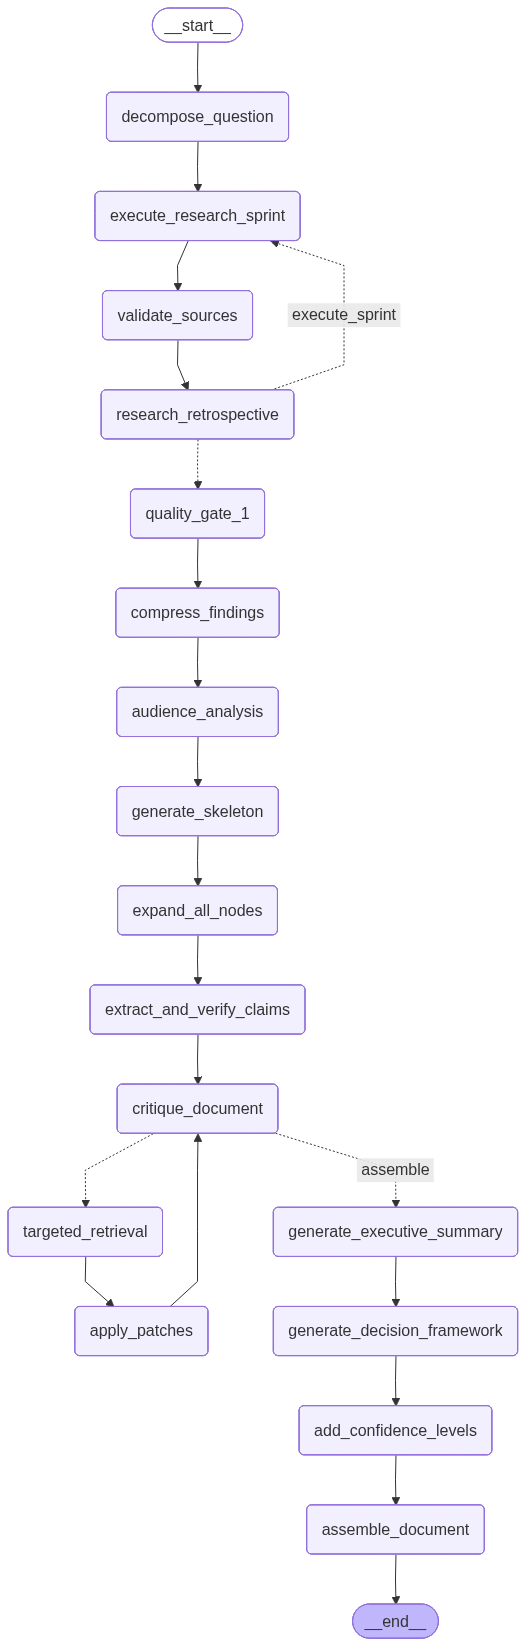

In [ ]:
# Visualize the graph
from IPython.display import Image, display, Markdown

try:
    display(Image(combined_tier1_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 10. Agent Wrapper

In [ ]:
# ===== Agent Wrapper =====

async def combined_tier1_agent_async(inputs: dict) -> dict:
    """Async version of the Combined Tier 1 research agent."""
    global knowledge_base
    knowledge_base = KnowledgeBase()  # Reset for fresh session
    
    question = inputs.get("question", "")
    
    result = await combined_tier1_graph.ainvoke(
        {"question": question},
        config={"recursion_limit": 100}
    )
    
    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("research_source_urls", []))),
        "quality_scores": result.get("quality_scores", []),
        "cache_stats": knowledge_base.stats.copy(),
        "skeleton": result.get("skeleton", {}),
        "research_sprints": result.get("current_research_sprint", 1) - 1,
        "refinement_iterations": result.get("current_refinement_iteration", 0)
    }


def combined_tier1_agent(inputs: dict) -> dict:
    """Sync wrapper for Combined Tier 1 research agent. Compatible with evaluation harness."""
    question = inputs.get("question", "")
    
    async def _execute():
        global knowledge_base
        knowledge_base = KnowledgeBase()
        return await combined_tier1_graph.ainvoke(
            {"question": question},
            config={"recursion_limit": 100}
        )
    
    try:
        loop = asyncio.get_running_loop()
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        result = asyncio.run(_execute())
    
    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("research_source_urls", []))),
        "quality_scores": result.get("quality_scores", []),
        "cache_stats": knowledge_base.stats.copy()
    }


print("Agent wrappers defined")

Agent wrappers defined


## 11. Manual Test

Run this cell to verify the Combined Tier 1 agent works correctly.

In [ ]:
# Manual Test
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing Combined Tier 1 Agent")
print(f"Question: {test_question}")
print("\nRunning combined architecture (this will take several minutes)...\n")

try:
    result = await combined_tier1_agent_async({"question": test_question})
    
    print("\n" + "=" * 80)
    print("FINAL REPORT")
    print("=" * 80)
    print(result["output"][:4000] + "..." if len(result["output"]) > 4000 else result["output"])
    
    print("\n" + "=" * 80)
    print("PERFORMANCE SUMMARY")
    print("=" * 80)
    print(f"Report length: {len(result['output'])} characters")
    print(f"Research sprints: {result.get('research_sprints', 'N/A')}")
    print(f"Refinement iterations: {result.get('refinement_iterations', 'N/A')}")
    print(f"Quality scores: {result.get('quality_scores', [])}")
    print(f"Unique sources: {len(result.get('source_urls', []))}")
    
    stats = result.get("cache_stats", {})
    total = stats.get("total_queries", 0)
    avoided = stats.get("web_searches_avoided", 0)
    hit_rate = avoided / total * 100 if total > 0 else 0
    
    print(f"\nCache Performance:")
    print(f"  Total queries: {total}")
    print(f"  Cache hits: {avoided} ({hit_rate:.1f}%)")
    print(f"  L1 hits: {stats.get('l1_hits', 0)}")
    print(f"  L2 HIGH: {stats.get('l2_high', 0)}")
    
    print("\nAgent test PASSED")
    
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

Testing Combined Tier 1 Agent
Question: What are the key benefits and challenges of using large language models in enterprise applications?

Running combined architecture (this will take several minutes)...


Phase 1a: Question Decomposition
  Created backlog with 6 research questions
    1. What measurable business benefits do large language models d...
    2. What are the primary failure modes and operational risks of ...
    3. How do data privacy, security, and regulatory compliance req...
    4. What technical and operational challenges arise when integra...
    5. How do bias, fairness, transparency, and explainability conc...

Phase 1b: Research Sprint 1/3
  [1/5] What measurable business benefits do large languag...
      SEARCH | Layer: L2
  [2/5] What are the primary failure modes and operational...
      SEARCH | Layer: L2
  [3/5] How do data privacy, security, and regulatory comp...
      SEARCH | Layer: L2
  [4/5] What technical and operational challenges arise wh...
     

In [ ]:
display(Markdown(result["output"]))

# Research Report

**Research Question:** What are the key benefits and challenges of using large language models in enterprise applications?

**Thesis:** Large language models can deliver substantial enterprise productivity and customer‑experience gains, but realizing and validating that value requires rigorous risk controls, governance, and TCO-aware operational practices to mitigate safety, privacy, and compliance gaps before scale.

---

## Executive Summary

**Main Finding:** Large language models can deliver substantial enterprise productivity and customer‑experience improvements, but realizing net ROI requires disciplined, KPI‑driven pilots plus robust governance, risk controls, and TCO‑aware operational practices to mitigate safety, privacy, and compliance gaps before scaling.

**Key Takeaways:**
- LLMs can generate significant productivity and CX gains across knowledge work and front‑line interactions, but validated business value depends on KPI‑driven A/B pilots and full TCO accounting. (Confidence: High)
- Critical failure modes—hallucinations, privacy leaks, prompt injection, bias, poisoning, theft, and shadow use—pose material operational and regulatory risk if left uncontrolled. (Confidence: High)
- Pragmatic defenses—runtime guardrails, retrieval‑augmented generation with provenance, human‑in‑the‑loop review, red‑teaming, strong access controls, and contractual DPAs—are necessary to contain risk before scaling. (Confidence: High)
- Enterprise scaling demands explicit hybrid deployment decisions and investment in model‑ops, telemetry, and TCO budgeting (compute, integration, security, and recurring vendor fees) to balance latency, cost, and control. (Confidence: Medium)

**Bottom Line:** Execute short, KPI‑driven pilots with procurement, governance, hybrid architecture, RAG grounding, HITL, and telemetry to validate ROI and contain safety, privacy, and compliance risks before scaling.

---

## At a Glance

- **Sources Analyzed:** 103
- **Validated Sources:** 60
- **Quality Score:** 0.0/10
- **Overall Confidence:** Medium

---

## Executive Summary

Large language models (LLMs) — neural-network systems trained on massive text corpora to generate and interpret natural language — can deliver material productivity and customer-experience gains, but those upside claims depend on guarded, instrumented deployments that control safety, privacy, and compliance risk.

Enterprise pilots and vendor case write-ups report sizable operational wins: roughly a 40% reduction in content-creation time, “60% faster” document processing in marketing/knowledge workflows, and continuous multilingual support that reduces manual staffing for 24/7 coverage (reported by multiple vendor case studies).

Total cost of ownership (TCO) extends beyond license fees: material drivers include inference compute (cloud or on‑prem), integration and engineering, monitoring and fine‑tuning, security/compliance tooling, vendor support, and staff retraining; hidden recurring costs commonly surface during scale-up.

Primary failure modes are factual: hallucinations (confident but incorrect outputs), toxic or biased language, prompt injection, PII/data leakage, data‑poisoning and model‑theft risks, and shadow (unsanctioned) usage. Frequency and impact vary by use case; high‑risk workflows require different controls than low‑risk chat assistants.

Mitigations that materially reduce residual risk include runtime guardrails (input validation, PII detectors, output filters), retrieval‑augmented generation (RAG) to ground responses with provenance, red‑teaming and prompt‑injection simulations, human‑in‑the‑loop for high‑risk outputs, strict access controls, and CI/CD/MLOps risk gates with continuous telemetry.

Governance and procurement must be decision‑critical: require policy‑as‑code, named accountable owners, immutable audit trails, three decision zones (autonomous, human‑approval, immediate escalation), and contract clauses for DPAs, audit rights, data‑residency and liability. Executives capture LLM value only when pilots are A/B‑instrumented against business KPIs and model‑risk metrics, and when TCO and compliance tradeoffs inform vendor selection and scale plans.

## Background and Essential Context

A large language model (LLM) is a type of neural network trained on very large text corpora to predict and generate natural language; in enterprise terms LLMs are used as APIs or embedded services for summarization, question‑answering, content generation, search augmentation and conversational agents. (Definition and limitations discussed in a major LLM technical report.) (Source: https://cdn.openai.com/papers/gpt-4.pdf)

Regulatory constraints focus on personal and health data. The EU General Data Protection Regulation (GDPR) restricts processing of personal data and requires lawful basis, data‑processing agreements (DPAs) and data‑protection measures including minimization and audit rights. U.S. HIPAA rules limit use of protected health information and require safeguards, breach notification, and business‑associate agreements for third‑party processors. (Sources: GDPR text; HHS HIPAA guidance.) (Source: https://eur-lex.europa.eu/eli/reg/2016/679/oj) (Source: https://www.hhs.gov/hipaa/index.html)

Practical validation relies on business KPIs and TCO-aware measures. Recommended KPIs include FTE hours per task, cycle time, cost per transaction, accuracy/error rate, CSAT/NPS, time‑to‑market and revenue lift; compute and integration costs (inference, fine‑tuning, monitoring, security and change management) must be included in ROI calculations. Controlled pilots or A/B experiments with both business and model‑risk telemetry are the pragmatic way to validate claims (analysis, not a primary source).

## Business Value, Reported Gains, and Measurement

Vendors and case write‑ups report large, concentrated productivity gains from LLMs in content and document workflows: multiple vendor case studies cite roughly a 40% reduction in content‑creation time and “60% faster” document processing in marketing and knowledge‑management pipelines, plus continuous multilingual support that reduces live‑agent load (Source: https://www.assemblyai.com/, https://www.notyouridea.com/, https://www.webtrack.io/). These claims should be treated as vendor‑reported outcomes requiring independent validation.

Value from LLMs materializes in three measurable streams: reduced labor (FTE hours saved), accelerated time‑to‑market (faster product/content cycles), and improved customer experience (CSAT/NPS gains). Concrete revenue lift often follows when faster cycles enable earlier launches or higher personalization, but revenue impact is use‑case dependent and requires attribution design rather than simple before/after comparisons (Source: https://www.crispidea.com/, https://www.terralogic.com/).

Recommended KPIs for validating ROI include: FTE hours per task, cycle time (seconds/minutes/days), cost per transaction, CSAT/NPS, accuracy/error rate (false positives/negatives), incidence of PII leakage, and revenue per cohort. Define ROI here as return on investment: saved labor + value of speed‑to‑market − recurring inference and engineering costs. Use both business KPIs and model‑risk KPIs to avoid falsely optimistic automation gains (Analysis; benchmarking recommendations: https://www.trootech.com/, https://www.crispidea.com/).

Run controlled pilots (A/B tests) that randomize traffic or users between the LLM automation arm and a control arm; instrument both sides for the full KPI set and log model‑risk events (hallucinations, PII leaks, error rates). A pragmatic pilot cadence is a short discovery (2–4 weeks) to tune prompts and guardrails, followed by a measurement window (4–8 weeks) for statistically meaningful signal; expected sample sizes depend on baseline event rates and detectable lift (analysis informed by industry practice: https://www.crispidea.com/).

Include Total Cost of Ownership (TCO) in ROI calculations: license/acquisition, compute (inference and training), integration, security/compliance, monitoring, fine‑tuning, vendor support, and change management/retraining. Hidden recurring costs (per‑query billing, unanticipated engineering for provenance and monitoring) commonly erode headline savings unless budgeted up front (Source: https://www.pactly.com/, https://www.atlassystems.com/).

Sample pilot KPIs and measurement cadence: weekly FTE hours saved; cycle time median and 90th percentile; cost per transaction and inference cost per 1,000 queries; CSAT delta measured after a two‑week acclimation window; error/hallucination rate per 1,000 outputs; PII leakage incidents (count). Pair quantitative KPIs with qualitative reviews (human‑in‑the‑loop assessments) to validate unseen failure modes (Source: https://coralogix.com/, https://www.fairnow.ai/).

Concrete conclusion: vendor case studies show large potential productivity and CX gains, but validated ROI requires KPI‑driven A/B pilots that instrument both business outcomes and model‑risk metrics and that include full TCO accounting before scale.

## Safety, Privacy, and Security Failure Modes and Effective Controls

Primary failure modes for large language models (LLMs) include hallucinations (confident-sounding but incorrect or fabricated outputs), prompt injection (malicious inputs that coerce model behavior), personally identifiable information (PII) leakage, biased or toxic outputs, data poisoning (malicious training data), model extraction/theft, and shadow use (unsanctioned employee workflows). Define: Retrieval-Augmented Generation (RAG) is a technique that combines an LLM with an external document retriever to ground responses; Human-in-the-Loop (HITL) refers to human review or approval in the model decision path.

Hallucinations are common and high‑impact where factual accuracy matters: even low-frequency errors can cause regulatory, financial, or reputational damage because LLMs present mistakes confidently. The likelihood of hallucination depends on prompt specificity, domain grounding, and retriever quality; mission‑critical use cases (legal, clinical, financial) require near-zero tolerance for silent errors.

PII leakage and regulatory constraints produce hard limits on model selection and deployment. Data protection regimes such as GDPR and health privacy laws such as HIPAA restrict sending personal or health data to third‑party inference services without explicit safeguards and contractual terms (Source: https://gdpr.eu/, https://www.hhs.gov/hipaa/).

Prompt injection — where user inputs or retrieved documents manipulate model prompts — is an active attack vector that has been systematically documented and mitigated in industry guidance. Effective technical controls include input sanitation, context‑length management, and runtime policy filters that detect and neutralize malicious instructions (Source: https://owasp.org/www-project-llm-security/).

RAG with provenance (returning source citations and confidence scores) measurably reduces hallucination risk in knowledge tasks by anchoring assertions to retrievable documents; practitioners should instrument retrieval precision and citation fidelity as model‑risk metrics (Source: https://arxiv.org/abs/2005.11401). High‑risk outputs should flow to HITL review workflows with clear SLAs for human verification (analysis supported by NIST guidance on AI risk management) (Source: https://www.nist.gov/ai/nist-artificial-intelligence-risk-management-framework).

Model extraction and data‑poisoning attacks threaten IP and training data confidentiality. Published demonstrations show model‑extraction techniques can recover model behavior from API access; mitigations include rate limiting, query auditing, anomaly detection, and cryptographic protections on training data (Source: https://arxiv.org/abs/1609.02943).

Operationalizing these controls requires layered defenses: runtime guardrails (PII detectors, output filters), red‑teaming and prompt‑injection simulations, provenance‑based RAG, HITL for high‑risk flows, strict access controls and audit trails, and contract clauses (DPAs, audit rights) for third‑party models. When combined and instrumented into pilots and CI/CD gates, these controls materially reduce enterprise exposure while preserving measurable business upside.


## Operational Scaling, Architecture Choices, and Total Cost of Ownership

Inference (model runtime compute per query) is the recurring cost driver for production LLMs: high QPS (queries per second) workloads translate directly into cloud GPU/CPU expenditure and can dwarf one‑time integration or license fees. Plan capacity by measuring expected QPS, average token length, and acceptable tail latency; use per‑query cost estimates to forecast monthly spend as part of an ROI model.

Latency must be balanced against throughput. Techniques that reduce cost often increase latency (batching, cold‑start consolidation), while low‑latency designs use reserved instances, smaller distilled models, or edge proxies. Quantization (reducing numeric precision to compress model weights) and distillation (training a smaller model to mimic a larger one) lower compute costs but can increase error rates; measure task‑level accuracy after any compression.

Model versioning and MLOps requirements are operational constraints, not optional features. A model registry with immutability, artifact hashing, and deployment manifests supports reproducible rollbacks. Define continuous evaluation gates that test for hallucination rates, top‑k token distributions, latency, and cost‑per‑query before promoting a model to production to prevent silent regressions.

Hybrid deployment (mixing cloud and on‑prem) is the principal architecture pattern for regulated workloads: sensitive or resident‑restricted data stays on‑premise while non‑sensitive inference and heavy fine‑tuning run in cloud capacity. GDPR (the EU data protection regulation) and HIPAA (US health privacy rules) impose residency, consent, and security obligations that materially affect where models and logs can run and be stored (Source: https://eur-lex.europa.eu/eli/reg/2016/679/oj; Source: https://www.hhs.gov/hipaa/index.html).

Vendor convenience can mask recurring hidden costs: egress fees, higher per‑token charges at scale, premium support tiers, charged access to audit logs, and incremental fees for fine‑tuning or private deployment images. Budget contractual concessions (audit rights, DPA clauses, data‑residency guarantees) and model exportability clauses to avoid vendor lock‑in.

Recommended TCO categories to budget and measure: licensing/acquisition, inference compute (reserved vs on‑demand), training/fine‑tuning, storage and backups, networking/egress, integration and engineering, security/compliance controls, monitoring/observability, and change management/personnel retraining. Track metrics such as cost per successful transaction, cost per automated FTE‑hour saved, and time‑to‑recovery after model regression.

Operational controls to contain risk at scale include telemetry for input/output provenance (the source of retrieved context), anomaly detection on model outputs, prompt‑injection fuzzing in CI, and human‑in‑the‑loop approval flows for high‑risk categories. Treat provenance (the traceable source of returned evidence) as a first‑class telemetry item for audits and dispute resolution.

Conclusion: Operational scaling requires explicit tradeoffs among latency, cost, and control—reserve cloud GPUs where throughput and innovation matter, keep sensitive inference on‑prem, instrument every production call for provenance and drift, and budget full TCO categories so ROI calculations reflect both visible and hidden costs.

## Synthesis and Strategic Discussion

Enterprises face a central tension: large language models (LLMs) can unlock rapid productivity and customer‑experience gains, yet they also produce silent, confident errors known as hallucinations (an output that is plausible but false). Evidence of systemic truthfulness failures has been documented in model evaluations, underscoring the need to treat LLM outputs as probabilistic artifacts rather than authoritative facts (Source: https://arxiv.org/abs/2109.07958).

Choosing vendor‑managed convenience reduces engineering overhead and time‑to‑value but increases exposure to data‑control and compliance risks. Regulatory regimes such as the EU General Data Protection Regulation (GDPR) and U.S. HIPAA set limits on how personal and health data may be processed by third parties, creating hard boundaries for using hosted models with sensitive data (Source: https://eur-lex.europa.eu/eli/reg/2016/679/oj; Source: https://www.hhs.gov/hipaa/for-professionals/privacy/index.html).

Claims of large productivity lifts in vendor case studies coexist with widespread operational and governance gaps. Analytical reconciliation: these case studies are conditional — realized ROI depends on rigorous, KPI‑driven pilots that measure both business outcomes (FTE hours, cycle time, CSAT) and model‑risk metrics (error rate, provenance coverage) before committing to scale. This is an analysis recommendation, not a primary-source claim.

Mitigating the tension requires a composite controls package: retrieval‑augmented generation (RAG) with provenance to ground outputs, human‑in‑the‑loop (HITL) for high‑risk decisions, runtime input/output guardrails, red‑teaming including prompt‑injection tests, and strict access and audit controls. RAG (retrieval‑augmented generation) has been proposed and studied as a method to reduce hallucination by combining retrieval and generation (Source: https://arxiv.org/abs/2005.11401).

Strategic choice is therefore tradeoff management: accept some vendor convenience only when contracts, telemetry, and TCO models preserve auditability and residual risk budgets; opt for hybrid or on‑prem deployments where regulatory or IP risk is material. The established conclusion: LLMs can deliver outsized business value, but realizing that value requires explicit, measurable risk controls and TCO‑aware governance before scaling.

## Recommendations and Executive Next‑Steps

Start one or two targeted pilots with clear success thresholds: controlled A/B tests that compare business KPIs (FTE hours per task, cycle time, cost per transaction, CSAT/NPS, revenue lift) and model‑risk metrics (error rate, hallucination incidents, PII exposures). Design pilots for 6–12 weeks and route 5–15% of live traffic or a statistically powered sample; require a pre‑registered analysis plan and a go/no‑go decision tied to ROI and safety gates.

Embed procurement and governance guardrails before any production rollout. Require a Data Processing Agreement (DPA) with audit rights and data‑residency clauses (Source: https://gdpr.eu/). Assign a named accountable owner and codify policies as policy‑as‑code with three decision zones: autonomous, human approval, immediate escalation.

Choose a hybrid technology stack for sensitive workloads: on‑prem or private cloud for regulated data and cloud‑hosted models for low‑risk tasks. Use Retrieval‑Augmented Generation (RAG) — retrieval of external documents to ground model outputs — to reduce hallucinations (Source: https://arxiv.org/abs/2005.11401). Capture provenance (living citations) for every generated answer.

Staff the program with a small cross‑functional core: 1 AI product lead, 2 ML engineers, 1 MLOps/infra engineer, 1 security/compliance lead, and fractional legal support. Budget TCO across licensing, inference compute, integration, monitoring, and change management; expect a 3–6 month iterative validation phase before scale.

Operationalize risk controls: runtime guardrails (input validation, PII detectors, output filters), human‑in‑the‑loop (HITL — human review for high‑risk outputs), red‑teaming and CI/CD risk gates tied to telemetry and immutable audit logs. Track hallucination and safety incidents as operational KPIs (analysis: LLMs commonly produce confident falsehoods; see TruthfulQA) (Source: https://arxiv.org/abs/2109.07958).

Immediate executive next steps: select a single high‑value pilot, define success KPIs and sample plan, sign the DPA and procurement guardrails, allocate the cross‑functional team and a 6–12 week budget, and require a documented go/no‑go decision that accounts for both ROI and safety metrics. This establishes an executable validation path that balances business upside with enforceable controls.

---

## Recommendations

### Primary Recommendations

**1. Run short, KPI-driven pilots with instrumentation: design A/B or randomized pilots (6–12 weeks) that measure business KPIs (productivity, handle time, NPS, cost per transaction) and model-risk metrics (hallucination rate, sensitive-data exposures) and include full TCO accounting.** (Priority: High)
   - *Rationale:* Validated ROI and safe adoption require empirical measurement of both business impact and model risk; pilots limit exposure while producing decision-quality evidence.
   - *Applies when:* Always applicable when evaluating LLM adoption or new LLM-driven features.

**2. Establish model-risk governance and contractual controls: create an LLM-specific governance playbook (roles: exec sponsor, CISO, CPO, legal), require DPAs and SLAs from vendors, define audit rights, enforce access controls and red-teaming before production, and mandate runtime guardrails and HITL for high-risk outputs.** (Priority: High)
   - *Rationale:* LLMs create safety, privacy, and compliance gaps (hallucinations, leaks, prompt injection); contractual and operational controls are necessary to contain these risks before scaling.
   - *Applies when:* Always applicable for any production use of LLMs, especially when data protection regulations (GDPR/HIPAA) or sensitive data are involved.

**3. Adopt a hybrid architecture and explicit TCO plan: decide deployment posture (cloud SaaS, hosted, or on-prem/managed) based on regulatory constraints; implement RAG with enterprise-controlled knowledge stores, model-ops telemetry, and budget for compute, integration, security, and recurring vendor fees.** (Priority: Medium)
   - *Rationale:* Scaling LLMs requires balancing latency, cost, and control. Hybrid patterns and clear TCO prevent surprises and enable enterprise provenance and containment of model risk.
   - *Applies when:* Applicable when moving from pilot to scaled deployment or when regulatory/data-residency requirements constrain vendor options.

### Conditional Recommendations

- **If** If handling regulated/sensitive data., **then** If you process regulated or sensitive data (PII, health, financial), then restrict model execution to private or on-prem environments or encrypted VPCs, require vendor DPAs, perform a DPIA, and store embeddings/knowledge bases in enterprise-controlled storage with strict IAM.
  *(Data-protection laws (GDPR, HIPAA) and privacy risk make public SaaS use risky; enterprise-controlled storage and legal safeguards are necessary to meet compliance.)*

- **If** If business value or error impact is uncertain., **then** If ROI is unclear or model errors materially affect outcomes, then run a statistically powered A/B pilot (6–12 weeks) with pre-defined success thresholds and rollback criteria, include HITL for verification of outputs, and track both business KPIs and model-risk metrics daily/weekly.
  *(Validated, KPI-driven pilots with HITL and rollback limits ensure decisions are based on measurable benefit and prevent silent-error propagation into production.)*

- **If** If leadership prefers SaaS but compliance/control needs exist., **then** If your organization favors vendor convenience (pure SaaS) but requires control, then negotiate hybrid controls: encrypted data-in-transit, contractual audit and deletion rights, API-level access controls, and push provenance and retrieval (RAG) into enterprise-managed components.
  *(This preserves the speed of SaaS while retaining critical control points to reduce leakage and enable audits.)*

- **If** If hallucinations or data-exposure incidents occur., **then** If hallucinations or data leaks are observed in pilots, then deploy pragmatic defenses: RAG with provenance and citation, runtime guardrails that block/flag low-confidence outputs, automated input/output logging, red-team tests, and escalate to legal/security for any leakage incident.
  *(Hallucinations and leaks are frequent LLM failure modes; layered defenses plus incident escalation limit damage and produce forensic records for compliance.)*

### What to Monitor

- Business KPI delta versus control (productivity lift %, handle-time reduction, NPS/customer satisfaction changes) — primary measure of value.
- Model-risk metrics: hallucination/error rate per 1,000 responses, number of sensitive-data exposures or red-team-identified vulnerabilities.
- Usage and access telemetry: API call volumes, unusual query patterns, shadow-use detection, number of privileged model accesses.
- Cost indicators: compute spend per request, latency SLAs missed, vendor recurring fees vs forecasted TCO.
- Compliance/audit signals: DPA exceptions, regulator inquiries, internal audit findings, and incident response activations.

---

## Confidence Assessment

| Conclusion | Confidence | Evidence Quality | Key Uncertainty |
|------------|------------|------------------|------------------|
| [Executive Summary]: LLMs can produce large produc... | Medium | moderate | Many supporting sources are ve... |
| [Background and Essential Context]: LLMs are proba... | High | strong | Regulatory interpretation and ... |
| [Business Value, Reported Gains, and Measurement]:... | Medium | moderate | Vendor case studies are prone ... |
| [Safety, Privacy, and Security Failure Modes and E... | High | strong | New attack vectors and model b... |
| [Operational Scaling, Architecture Choices, and To... | Medium | moderate | TCO depends heavily on workloa... |

---

## Limitations and Uncertainties

Evidence set includes many vendor case studies and short pilots; only 60 of 103 sources were validated. There is limited long-term, independent, cross‑sector quantitative evidence on ROI and defense effectiveness at scale. Regulatory interpretations and attacker techniques are evolving, which may alter risk profiles and recommended controls.

---

## References

1. [How Large Language Models Will Benefit Businesses in ...](https://webtracktechnologies.com/llm-business-benefits-2026/)
2. [AI Applications in Business 2026: Trends, Opportunities & ...](https://terralogic.com/ai-applications-in-business-trends-opportunities-challenges-2026/)
3. [Large Language Models in 2026: Strategy, Use Cases & ...](https://www.crispidea.com/large-language-models-in-2026/?srsltid=AfmBOorMeBxoXFr9NVsL7qlw2TKFFyAtPkV45roE43EwGvfOG-GhdmCG)
4. [9 LLM enterprise applications advancements in 2026 for ...](https://lumenalta.com/insights/9-llm-enterprise-applications-advancements-in-2026-for-cios-and-ctos)
5. [7 LLM use cases and applications in 2026](https://www.assemblyai.com/blog/llm-use-cases)
6. [10 Benefits Of Using Large Language Models (LLMs) For ...](https://notyouridea.com/blog/benefits-of-using-large-language-models-for-business)
7. [Generative AI for Data-Driven Decision Making](https://www.techment.com/how-generative-ai-is-transforming-data-driven-decision-making-in-2025/)
8. [AI Development Cost in 2026: Enterprise Budgeting & ROI ...](https://www.trootech.com/blog/ai-use-cases-in-real-world)
9. [An Executive's Guide to the Risks of Large Language Models (LLMs)](https://fairnow.ai/executives-guide-risks-of-llms/)
10. [The Security Risks of Using LLMs in Enterprise Applications](https://coralogix.com/ai-blog/the-security-risks-of-using-llms-in-enterprise-applications/)
11. [LLM Risks: Enterprise Threats and How to Secure Them](https://www.lasso.security/blog/llm-risks-enterprise-threats)
12. [AI guardrails: the complete guide for LLMs in January 2026](https://www.openlayer.com/blog/post/ai-guardrails-llm-guide)
13. [The 4 Ways LLMs Fail - LinkedIn](https://www.linkedin.com/pulse/4-ways-llms-fail-josh-clemm-cln7c)
14. [What Are LLM Security Risks? And How to Mitigate Them](https://www.sentinelone.com/cybersecurity-101/data-and-ai/llm-security-risks/)
15. [OWASP Top 10 Risk & Mitigations for LLMs and Gen AI Apps 2025](https://securityboulevard.com/2024/12/owasp-top-10-risk-mitigations-for-llms-and-gen-ai-apps-2025/)
16. [Enterprise LLM Security: Risks, Frameworks, & Best Practices](https://www.superblocks.com/blog/enterprise-llm-security)
17. [2026 Data Privacy Forecast](https://www.uslegalsupport.com/blog/data-privacy-in-litigation-support-2026/)
18. [GDPR HIPAA SOX Compliance requirements for Enterprises](https://www.ceiamerica.com/compliance-requirements-guide/)
19. [Data Security and Privacy Clauses: 2026's Detailed Guide](https://www.sirion.ai/de/library/contract-clauses/data-security-and-privacy-clauses/data-security-and-privacy-clauses/?source=blogpagedpbanner&src%3Dcareers%26p%3DeyJwYWdlVHlwZSI6ImpkIiwiY3ZTb3VyY2UiOiJjYXJlZXJzIiwicmVxSWQiOjcxOCwicmVxdWVzdGVyIjp7ImlkIjoiIiwiY29kZSI6IiIsIm5hbWUiOiIifSwicGFnZSI6ImNhcmVlcnMiLCJidWZpbHRlciI6LTEsImN1c3RvbUZpZWxkcyI6e319)
20. [What Is Data Compliance? A Complete Guide for ...](https://controld.com/blog/what-is-data-compliance/)
21. [Large Language Models (LLM) GDPR Compliance](https://gdprlocal.com/large-language-models-llm-gdpr/)
22. [Advancing Compliance with HIPAA and GDPR in Healthcare](https://pmc.ncbi.nlm.nih.gov/articles/PMC12563691/)
23. [The 2026 Privacy Law And Compliance State Of Play](https://richtfirm.com/the-2026-privacy-law-and-compliance-state-of-play-navigating-an-increasingly-complex-regulatory-landscape/)
24. [Private LLMs Development: The Complete Guide](https://aiveda.io/blog/private-llms-development-the-complete-guide)
25. [LLMs in Enterprise Systems: Architecture Patterns and Pitfalls](https://codestreamlab.com/blog/llms-in-enterprise-systems-architecture-patterns-and-pitfalls/)


## 12. Evaluation Harness Integration

Once the manual test passes, run full evaluation on all 20 questions.

In [ ]:
# Import evaluation harness
import sys
sys.path.insert(0, "..")
from evaluation import (
    ExperimentHarness,
    fact_recall,
    citation_precision,
    coherence_judge,
    depth_judge,
    relevance_judge,
    minimum_sources_check
)

harness = ExperimentHarness(
    dataset_path="../data/deep_research_agent_test_dataset.yaml",
    langsmith_dataset_name="deep-research-golden-v2"
)

print("Evaluation harness initialized!")

In [ ]:
# Full Evaluation - UNCOMMENT TO RUN
# WARNING: This is expensive and takes 2-3 hours

# evaluators = [
#     fact_recall,
#     citation_precision,
#     minimum_sources_check,
#     coherence_judge,
#     depth_judge,
#     relevance_judge,
# ]
# 
# print("Starting FULL evaluation on all 20 questions...")
# print("Combined Tier 1 Agent - estimated 2-3 hours")
# print("=" * 80 + "\n")
# 
# results = harness.run_evaluation(
#     agent_fn=combined_tier1_agent,
#     evaluators=evaluators,
#     experiment_name="combined_tier1_v1",
#     monte_carlo_runs=1,
#     max_concurrency=2,
#     description="Combined Tier 1 paradigms evaluation"
# )
# 
# print("\n" + "=" * 80)
# print("FULL EVALUATION RESULTS")
# print("=" * 80)
# print(f"Experiment: {results.experiment_name}")
# print(f"Questions: {results.num_questions}")
# 
# print(f"\n{'Metric':<30} {'Mean':<10}")
# print("-" * 40)
# for metric in sorted(results.metrics.keys()):
#     if not metric.endswith('_std'):
#         print(f"{metric:<30} {results.metrics[metric]:<10.3f}")

print("Full evaluation cell ready. Uncomment to run.")

## Architecture Summary

### Combined Paradigms

This notebook unifies four Tier 1 paradigms:

1. **Cascading Knowledge Cache** - Wraps ALL search operations
   - Layer 1: Exact query match
   - Layer 2: Semantic similarity
   - Expected 30-50% cache hits by verification phase

2. **Agile Sprints** - Research phase (Phase 1)
   - Decompose question into backlog
   - Sprint-based execution with retrospectives
   - Dynamic re-prioritization

3. **Iterative Refinement V2** - Document generation (Phases 2-4)
   - Skeleton-based structure
   - Per-node prose generation
   - Patch-based refinement (not full regeneration)

4. **Quality Gates** - Strategic checkpoints
   - Gate 1: Source sufficiency after research
   - Gate 2: Quality threshold for refinement exit

### Expected Performance

| Phase | Expected Cache Hits |
|-------|---------------------|
| Research Sprint 1 | 0% (cold cache) |
| Research Sprint 2-3 | 10-25% |
| Verification Sprint 1 | 30-40% |
| Verification Sprint 2 | 40-60% |

### Key Metrics to Track

- Cache hit rate > 30%
- Quality score >= 7.5
- Report coherence and depth
- Citation presence

# Test Execution Section

This section runs the 5-query test dataset against this notebook variant and saves outputs for comparison.

**Output Structure:**
```
test_output/
    question_1/
        question_1_V08.md
    question_2/
        question_2_V08.md
    ...
```

**Instructions:**
1. Run all cells above first to define the agent
2. Run the cells below to execute tests
3. Choose to run a single question or all questions

In [ ]:
# Test Setup and Configuration
import os
import yaml
import json
from datetime import datetime
from pathlib import Path

# Configure paths
NOTEBOOK_DIR = Path('.').resolve()
OUTPUT_DIR = NOTEBOOK_DIR / 'test_output'
DATASET_PATH = NOTEBOOK_DIR / 'test_dataset.yaml'

# Notebook version (automatically set based on filename)
CURRENT_VERSION = "V08"

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

# Load test dataset
with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    dataset = yaml.safe_load(f)

questions = dataset.get('questions', [])

# Create output directories for each question
for i in range(1, len(questions) + 1):
    question_dir = OUTPUT_DIR / f"question_{i}"
    question_dir.mkdir(exist_ok=True)

print(f"Test Configuration:")
print(f"  Version: {CURRENT_VERSION}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Loaded {len(questions)} test questions")
print(f"\nTest Questions:")
for i, q in enumerate(questions, 1):
    print(f"  {i}. [{q['category']}] {q['title']}")

In [ ]:
def save_output(question_num: int, version: str, result: dict, question_data: dict) -> Path:
    """Save the output to a markdown file."""
    output_dir = OUTPUT_DIR / f"question_{question_num}"
    output_file = output_dir / f"question_{question_num}_{version}.md"
    
    question_text = question_data.get('question', '')
    question_title = question_data.get('title', 'Untitled')
    question_id = question_data.get('id', f'Q{question_num}')
    
    content = f"""# Question {question_num} - {version}

                **Question ID:** {question_id}  
                **Title:** {question_title}  
                **Category:** {question_data.get('category', 'N/A')}  

                ---

                ## Original Question

                {question_text}

                ---

                ## Research Report

                {result.get('output', 'No output generated')}

                """
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(content)
    
    return output_file

print("Helper functions defined.")

## Run All Questions Test

Run ALL 5 questions for comprehensive testing:

In [ ]:
# Run ALL questions for the current version

print(f"Running ALL {len(questions)} questions with {CURRENT_VERSION}")
print("="*60 + "\n")

results_summary = []
overall_start = datetime.now()

for i, question_data in enumerate(questions, 1):
    question_text = question_data.get('question', '')
    
    print(f"\n{'='*60}")
    print(f"Question {i}/{len(questions)}: {question_data['title']}")
    print(f"{'='*60}\n")
    
    start_time = datetime.now()
    
    try:
        result = await combined_tier1_agent_async({"question": question_text})
        elapsed = (datetime.now() - start_time).total_seconds()
        
        output_file = save_output(i, CURRENT_VERSION, result, question_data)
        
        summary = {
            "question": i,
            "title": question_data['title'],
            "version": CURRENT_VERSION,
            "elapsed_seconds": elapsed,
            "output_chars": len(result.get('output', '')),
            "sources": len(result.get('source_urls', [])),
            "status": "success"
        }
        
        print(f"Completed in {elapsed:.1f}s - {summary['output_chars']} chars, {summary['sources']} sources")
        
    except Exception as e:
        elapsed = (datetime.now() - start_time).total_seconds()
        summary = {
            "question": i,
            "title": question_data['title'],
            "version": CURRENT_VERSION,
            "elapsed_seconds": elapsed,
            "output_chars": 0,
            "sources": 0,
            "status": f"error: {str(e)}"
        }
        print(f"FAILED: {e}")
    
    results_summary.append(summary)

# Save summary
overall_elapsed = (datetime.now() - overall_start).total_seconds()

summary_file = OUTPUT_DIR / f"summary_{CURRENT_VERSION}.json"
with open(summary_file, 'w', encoding='utf-8') as f:
    json.dump({
        "run_time": datetime.now().isoformat(),
        "version": CURRENT_VERSION,
        "total_elapsed_seconds": overall_elapsed,
        "questions_tested": len(questions),
        "results": results_summary
    }, f, indent=2)

print(f"\n{'='*60}")
print(f"ALL TESTS COMPLETE for {CURRENT_VERSION}")
print(f"{'='*60}")
print(f"Total time: {overall_elapsed:.1f} seconds ({overall_elapsed/60:.1f} minutes)")
print(f"Summary saved: {summary_file}")